# Load Files

In [ ]:
# !rm -rf data
# !rm -rf data_manipulation_for_aml_gp_maxent
# !rm -rf maxent
# !rm -rf sample_data
# !rm -rf data_train_extra.txt
# !rm -rf df_targets_by_region.txt
# !rm -rf explore_species_data.py
# !rm -rf maxentResults

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=17PSaBl2ooeW0keMGJiVWUGQmwCaN2GcNiBwSrER64fw 



Train Stats:
Number of species in train set:            500
Number of train locations:                 272037
Average number of locations per species:   544.074
Minimum number of locations for a species: 50
Maximum number of locations for a species: 2000

Displaying random species:
65864 - Ingerophrynus celebensis


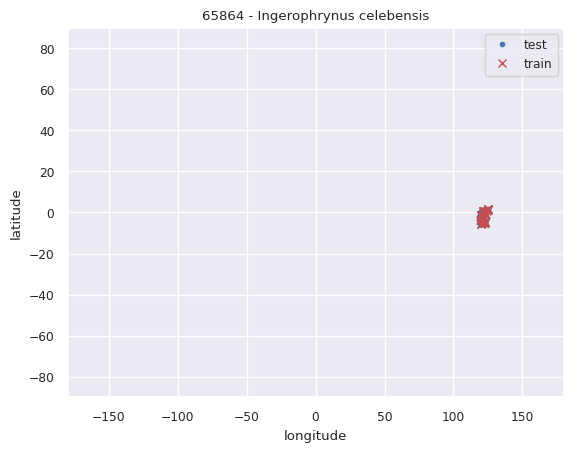

<Figure size 640x480 with 0 Axes>

In [ ]:
# Load data
!pip install gdown --upgrade --quiet
!pip install geodatasets --upgrade --quiet
!pip install libpysal --upgrade --quiet
!pip install geopandas --upgrade --quiet
!pip install libpysal esda --upgrade --quiet
import gdown
# url = 'https://drive.google.com/drive/folders/1Jq_6cHJK1iPziKqKLlGo9x9ocMCTuPZP?usp=drive_link'
# gdown.download_folder(url, quiet=True, use_cookies=False)
# !cp -r data/* .
# %run explore_species_data.py

# Explore_species_data.py

## Content of script

Script demonstrating simple data loading and visualization.

Data Format:

There are two files 'species_train.npz', and 'species_test.npz'
For the train data, we have the geographical coordinates where different
species have been observed. This data has been collected by citizen scientists
so it is noisy.
For the test data, we have a set of locations for all species from the training,
set and for each location we know if a species is present there or not.

You can find out information about each species by appending the taxon_id to this
URL, e.g. for 22956: 'Leptodactylus mystacinus', the URL is:
https://www.inaturalist.org/taxa/22956
note some species might not be on the website anymore

Possible questions to explore:
 - train a separate model to predict what locations a species of interest is present
 - train a single model instead of per species model
 - how to deal with "positive only data"
 - dealing with noisy/biased training data
 - using other input features e.g. climate data from  WorldClim Bioclimatic
   variables  https://www.worldclim.org/data/worldclim21.html
 - how to evaluate e.g. what is a good metric to use?

Data sources:
 -  train data is from iNaturalist -  www.inaturalist.org
 -  test data is IUCN - https://www.iucnredlist.org/resources/spatial-data-download
"""

```
import numpy as np
import matplotlib.pyplot as plt
```

### Loading training data
```
data = np.load('species_train.npz')
train_locs = data['train_locs']  # 2D array, rows are number of datapoints and
                                 # columns are "latitude" and "longitude"
train_ids = data['train_ids']    # 1D array, entries are the ID of the species
                                 # that is present at the corresponding location in train_locs
species = data['taxon_ids']      # list of species IDe. Note these do not necessarily start at 0 (or 1)
species_names = dict(zip(data['taxon_ids'], data['taxon_names']))  # latin names of species
```

### Loading test data
```
data_test = np.load('species_test.npz', allow_pickle=True)
test_locs = data_test['test_locs']    # 2D array, rows are number of datapoints
                                      # and columns are "latitude" and "longitude"
```
#### data_test['test_pos_inds'] is a list of lists, where each list corresponds to the indices in test_locs where a given species is present, it can be assumed that they are not present in the other locations
```
test_pos_inds = dict(zip(data_test['taxon_ids'], data_test['test_pos_inds']))    
```

### Data stats
```
print('Train Stats:')
print('Number of species in train set:           ', len(species))
print('Number of train locations:                ', train_locs.shape[0])
_, species_counts = np.unique(train_ids, return_counts=True)
print('Average number of locations per species:  ', species_counts.mean())
print('Minimum number of locations for a species:', species_counts.min())
print('Maximum number of locations for a species:', species_counts.max())
```


### Plot train and test data for a random species
```
plt.close('all')
plt.figure(0)

sp = np.random.choice(species)
print('\nDisplaying random species:')
print(str(sp) + ' - ' + species_names[sp])
```

### Get test locations and plot
#### Test_inds_pos is the locations where the selected species is present
#### Test_inds_neg is the locations where the selected species is not present
```
test_inds_pos = test_pos_inds[sp]  
test_inds_neg = np.setdiff1d(np.arange(test_locs.shape[0]), test_pos_inds[sp])
plt.plot(test_locs[test_inds_pos, 1], test_locs[test_inds_pos, 0], 'b.', label='test')
```

### Get train locations and plot
```
train_inds_pos = np.where(train_ids == sp)[0]
plt.plot(train_locs[train_inds_pos, 1], train_locs[train_inds_pos, 0], 'rx', label='train')

plt.title(str(sp) + ' - ' + species_names[sp])
plt.grid(True)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.legend()
plt.show()
```



## Run script

Train Stats:
Number of species in train set:            500
Number of train locations:                 272037
Average number of locations per species:   544.074
Minimum number of locations for a species: 50
Maximum number of locations for a species: 2000

Displaying random species:
7868 - Oriolus auratus


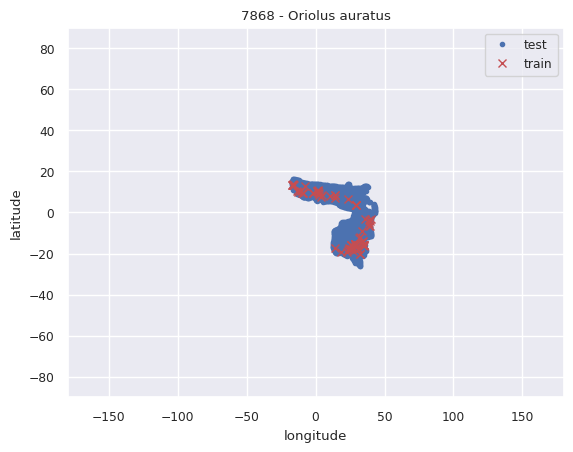

<Figure size 640x480 with 0 Axes>

In [ ]:
%run explore_species_data.py

# Data Processing

## Visualisations of data (Rhodri)

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import pandas as pd
import seaborn as sns
from PIL import Image

import rasterio
from rasterio.enums import ColorInterp
from rasterio.plot import show
from rasterio.windows import Window

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# loading training data
data = np.load('species_train.npz')
train_locs = data['train_locs']  # 2D array, rows are number of datapoints and
                                 # columns are "latitude" and "longitude"
train_ids = data['train_ids']    # 1D array, entries are the ID of the species
                                 # that is present at the corresponding location in train_locs
species = data['taxon_ids']      # list of species IDe. Note these do not necessarily start at 0 (or 1)
species_names = dict(zip(data['taxon_ids'], data['taxon_names']))  # latin names of species

# loading test data
data_test = np.load('species_test.npz', allow_pickle=True)
test_locs = data_test['test_locs']    # 2D array, rows are number of datapoints
                                      # and columns are "latitude" and "longitude"
# data_test['test_pos_inds'] is a list of lists, where each list corresponds to
# the indices in test_locs where a given species is present, it can be assumed
# that they are not present in the other locations
test_pos_inds = dict(zip(data_test['taxon_ids'], data_test['test_pos_inds']))

In [ ]:
#df is dataframe from base training data
df = pd.DataFrame({'id': data['train_ids']})

df['latitude'] = data['train_locs'][:, 0]
df['longitude'] = data['train_locs'][:, 1]

#df_extra is dataframe from extra training data
data_extra = np.load('species_train_extra.npz')
df_extra = pd.DataFrame({'id': data_extra['train_ids']})
df_extra['latitude'] = data_extra['train_locs'][:, 0]
df_extra['longitude'] = data_extra['train_locs'][:, 1]

#df_all is dataframce of base plus extra
df_all = pd.concat([df, df_extra])
df_all= df_all.dropna()

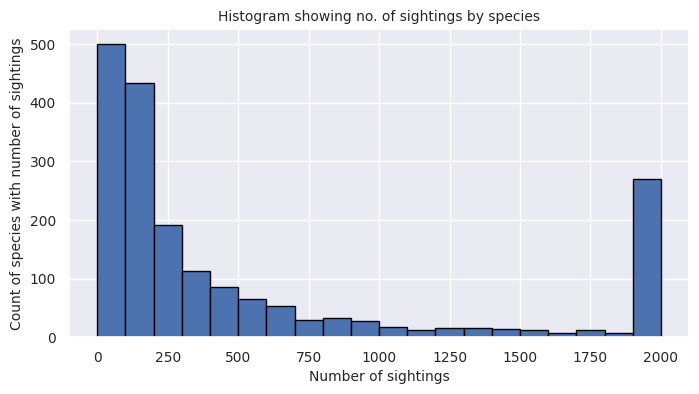

In [ ]:
#show histogram of 500 species in dataset
unique, counts = np.unique(data_extra['train_ids'], return_counts=True)
array_u_c = np.transpose(np.array([unique, counts]))
array_u_c_sort = array_u_c[array_u_c[:, 1].argsort()]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
n, bins, gaps = axs.hist(array_u_c[:, 1], bins=list(range(0,2100,100)), edgecolor='black')
plt.title('Histogram showing no. of sightings by species', fontsize = 10)
plt.xlabel('Number of sightings', fontsize = 10)
plt.ylabel('Count of species with number of sightings', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
#bin to 1 degree
df_int = df.astype(int)
df_all_int = df_all.astype(int)

#pivot and group by long / lat
pivoted_df_int = df_int.groupby(['latitude', 'longitude'])['id'].value_counts().unstack(fill_value=0).reset_index()
pivoted_df_all_int = df_all_int.groupby(['latitude', 'longitude'])['id'].value_counts().unstack(fill_value=0).reset_index()

# Rename columns
pivoted_df_int.columns = ['latitude', 'longitude'] + [f'id_{id_val}' for id_val in pivoted_df_int.columns[2:]]
pivoted_df_all_int.columns = ['latitude', 'longitude'] + [f'id_{id_val}' for id_val in pivoted_df_all_int.columns[2:]]

In [ ]:
#duplication check and then correlation on species base data binned to 1 degree
duplicate_cols_int = pivoted_df_int.columns[pivoted_df_int.T.duplicated()]
print("Duplicate Cols", duplicate_cols_int)
corr_matrix = pivoted_df_int.corr()
corr_matrix = corr_matrix.fillna(0)
corr_matrix_uns = corr_matrix.unstack()
sorted_pairs = corr_matrix_uns.sort_values(kind="quicksort")
#print(sorted_pairs)

Duplicate Cols Index([], dtype='object')


In [ ]:
#clustering of correlation output for visuals (dendogram optional)
plt.figure(figsize =(36,24))
dissimilarity = 1 - abs(corr_matrix)
Z = linkage(squareform(dissimilarity), 'complete')
#dendrogram(Z, labels = pivoted_df.columns, orientation = 'top', leaf_rotation = 90)

threshold = .98
labels = fcluster(Z, threshold, criterion = 'distance')
print(len(set(labels)))
labels_order = np.argsort(labels)
for idx, i in enumerate(pivoted_df_int.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(pivoted_df_int[i])
    else:
        df_to_append = pd.DataFrame(pivoted_df_int[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)
corr_matrix_clustered = clustered.corr()

104


KeyboardInterrupt: 

<Figure size 3600x2400 with 0 Axes>

In [ ]:
#plot heatmap of X correlation
sns.set(font_scale=.5)
plt.figure(figsize = (16,14), dpi = 240)
heatmap_clustered = sns.heatmap(corr_matrix_clustered, xticklabels=True, yticklabels=True)
heatmap_clustered.set_xticklabels(heatmap_clustered.get_xmajorticklabels(), fontsize = 5)
heatmap_clustered.set_yticklabels(heatmap_clustered.get_ymajorticklabels(), fontsize = 5)
plt.show()


In [ ]:
#Breaking the world in to continents (base)
df_Europe_filter = df[(df.latitude > 36) & (df.latitude <=90) & (df.longitude > -20) & (df.longitude <= 60) ].copy()
df_NA_cont_filter = df[(df.latitude > 12) & (df.latitude <=90) & (df.longitude > -180) & (df.longitude <= -20) ].copy()
df_SA_cont_filter = df[(df.latitude > -60) & (df.latitude <=12) & (df.longitude > -100) & (df.longitude <= -20) ].copy()
df_A_ME_cont_filter = df[(df.latitude > -60) & (df.latitude <=36) & (df.longitude > -20) & (df.longitude <= 60) ].copy()
df_Oce_West_filter = df[(df.latitude > -60) & (df.latitude <=-10) & (df.longitude > 60) & (df.longitude <= 180) ].copy()
df_Oce_East_filter = df[(df.latitude > -60) & (df.latitude <=12) & (df.longitude > -180) & (df.longitude <= -100) ].copy()
df_Asia_filter = df[(df.latitude > -10) & (df.latitude <=90) & (df.longitude > 60) & (df.longitude <= 180) ].copy()
df_Ant_filter = df[(df.latitude > -90) & (df.latitude <=-60) & (df.longitude > -180) & (df.longitude <= 180) ].copy()

In [ ]:
#Breaking the world in to continents (all training data)
df_all_Europe_filter = df_all[(df_all.latitude > 36) & (df_all.latitude <=90) & (df_all.longitude > -32) & (df_all.longitude <= 60) ].copy()
df_all_NA_cont_filter = df_all[(df_all.latitude > 12) & (df_all.latitude <=90) & (df_all.longitude > -180) & (df_all.longitude <= -32) ].copy()
df_all_SA_cont_filter = df_all[(df_all.latitude > -60) & (df_all.latitude <=12) & (df_all.longitude > -100) & (df_all.longitude <= -32) ].copy()
df_all_A_ME_cont_filter = df_all[(df_all.latitude > -60) & (df_all.latitude <=36) & (df_all.longitude > -32) & (df_all.longitude <= 60) ].copy()
df_all_Oce_West_filter = df_all[(df_all.latitude > -60) & (df_all.latitude <=-10) & (df_all.longitude > 60) & (df_all.longitude <= 180) ].copy()
df_all_Oce_East_filter = df_all[(df_all.latitude > -60) & (df_all.latitude <=12) & (df_all.longitude > -180) & (df_all.longitude <= -100) ].copy()
df_all_Asia_filter = df_all[(df_all.latitude > -10) & (df_all.latitude <=90) & (df_all.longitude > 60) & (df_all.longitude <= 180) ].copy()
df_all_Ant_filter = df_all[(df_all.latitude > -90) & (df_all.latitude <=-60) & (df_all.longitude > -180) & (df_all.longitude <= 180) ].copy()
df_NA_filter = df_all_NA_cont_filter.copy()

In [ ]:
#plot data by continent
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
geometry_Europe_filter = [Point(xy) for xy in zip(df_all_Europe_filter['longitude'], df_all_Europe_filter['latitude'])]
gdf_Europe_filter = GeoDataFrame(df_all_Europe_filter, geometry=geometry_Europe_filter)
geometry_NA_cont_filter = [Point(xy) for xy in zip(df_all_NA_cont_filter['longitude'], df_all_NA_cont_filter['latitude'])]
gdf_NA_cont_filter = GeoDataFrame(df_all_NA_cont_filter, geometry=geometry_NA_cont_filter)
geometry_A_ME_cont_filter = [Point(xy) for xy in zip(df_all_A_ME_cont_filter['longitude'], df_all_A_ME_cont_filter['latitude'])]
gdf_A_ME_cont_filter = GeoDataFrame(df_all_A_ME_cont_filter, geometry=geometry_A_ME_cont_filter)
geometry_SA_cont_filter = [Point(xy) for xy in zip(df_all_SA_cont_filter['longitude'], df_all_SA_cont_filter['latitude'])]
gdf_SA_cont_filter = GeoDataFrame(df_all_SA_cont_filter, geometry=geometry_SA_cont_filter)
geometry_Oce_West_filter = [Point(xy) for xy in zip(df_all_Oce_West_filter['longitude'], df_all_Oce_West_filter['latitude'])]
gdf_Oce_West_filter = GeoDataFrame(df_all_Oce_West_filter, geometry=geometry_Oce_West_filter)
geometry_Oce_East_filter = [Point(xy) for xy in zip(df_all_Oce_East_filter['longitude'], df_all_Oce_East_filter['latitude'])]
gdf_Oce_East_filter = GeoDataFrame(df_all_Oce_East_filter, geometry=geometry_Oce_East_filter)
geometry_Asia_filter = [Point(xy) for xy in zip(df_all_Asia_filter['longitude'], df_all_Asia_filter['latitude'])]
gdf_Asia_filter = GeoDataFrame(df_all_Asia_filter, geometry=geometry_Asia_filter)
geometry_Ant_filter = [Point(xy) for xy in zip(df_all_Ant_filter['longitude'], df_all_Ant_filter['latitude'])]
gdf_Ant_filter = GeoDataFrame(df_all_Ant_filter, geometry=geometry_Ant_filter)
map = gdf_Europe_filter.plot(ax=world.plot(figsize=(100, 6)), marker='x', color='g', markersize=1);
gdf_NA_cont_filter.plot(ax=map, marker='x', color = 'r', markersize=1)
gdf_A_ME_cont_filter.plot(ax=map, marker='x', color = 'y', markersize=1)
gdf_SA_cont_filter.plot(ax=map, marker='x', color = 'purple', markersize=1)
gdf_Oce_West_filter.plot(ax=map, marker='x', color = 'orange', markersize=1)
gdf_Oce_East_filter.plot(ax=map, marker='x', color = 'orange', markersize=1)
gdf_Asia_filter.plot(ax=map, marker='x', color = 'g', markersize=1)
gdf_Ant_filter.plot(ax=map, marker='x', color = 'purple', markersize=1)
plt.tick_params(labelsize = 10)

In [ ]:
#Create bins for 1 degree, 0.5 degrees and 2 degrees for full dataset

df_all_bin_1 = df_all.copy()
df_all_bin_1['lat_bin-1']= (df_all['latitude']).astype(int)
df_all_bin_1['long_bin-1']= (df_all['longitude']).astype(int)

df_all_bin_p25 = df_all.copy()
df_all_bin_p25['lat_bin-0.25']= ((4*(df_all['latitude'])).astype(int))/4
df_all_bin_p25['long_bin-0.25']= ((4*(df_all['longitude'])).astype(int))/4

df_all_bin_p5 = df_all.copy()
df_all_bin_p5['lat_bin-0.5']= ((2*(df_all['latitude'])).astype(int))/2
df_all_bin_p5['long_bin-0.5']= ((2*(df_all['longitude'])).astype(int))/2

df_all_bin_4 = df_all.copy()
df_all_bin_4['lat_bin-4']= ((.25*(df_all['latitude'])).astype(int))/.25
df_all_bin_4['long_bin-4']= ((.25*(df_all['longitude'])).astype(int))/.25

df_all_bin_2 = df_all.copy()
df_all_bin_2['lat_bin-2']= ((.5*(df_all['latitude'])).astype(int))/.5
df_all_bin_2['long_bin-2']= ((.5*(df_all['longitude'])).astype(int))/.5


In [ ]:
#pivot and add columns with ID info  - global 0.25 degree bins
pivoted_df_all_bin_p25 = df_all_bin_p25.groupby(['lat_bin-0.25', 'long_bin-0.25'])['id'].value_counts().unstack(fill_value=0).reset_index()
# Rename columns
pivoted_df_all_bin_p25.columns = ['lat_bin', 'long_bin'] + [f'id_{id_val}' for id_val in pivoted_df_all_bin_p25.columns[2:]]
pivoted_df_all_bin_p25.head(5)
#add final column of total sightings of all species
pivoted_df_all_bin_p25['Total_Sightings'] = (pivoted_df_all_bin_p25.loc[ : , ['id' in i for i in pivoted_df_all_bin_p25.columns]]).sum(axis=1)
pd.set_option('display.max_columns', None)
sp_cols_p25 = [clm for clm in pivoted_df_all_bin_p25.columns if 'id' in clm]
pivoted_df_all_bin_p25['Unique_species']= (pivoted_df_all_bin_p25[sp_cols_p25]>0).sum(axis=1)


#pivot and add columns with ID info  - global 0.5 degree bins
pivoted_df_all_bin_p5 = df_all_bin_p5.groupby(['lat_bin-0.5', 'long_bin-0.5'])['id'].value_counts().unstack(fill_value=0).reset_index()
# Rename columns
pivoted_df_all_bin_p5.columns = ['lat_bin', 'long_bin'] + [f'id_{id_val}' for id_val in pivoted_df_all_bin_p5.columns[2:]]
pivoted_df_all_bin_p5.head(5)
#add final column of total sightings of all species
pivoted_df_all_bin_p5['Total_Sightings'] = (pivoted_df_all_bin_p5.loc[ : , ['id' in i for i in pivoted_df_all_bin_p5.columns]]).sum(axis=1)
pd.set_option('display.max_columns', None)
sp_cols_1 = [clm for clm in pivoted_df_all_bin_p5.columns if 'id' in clm]
pivoted_df_all_bin_p5['Unique_species']= (pivoted_df_all_bin_p5[sp_cols_1]>0).sum(axis=1)


#pivot and add columns with ID info - global 1 degree bins
pivoted_df_all_bin_1 = df_all_bin_1.groupby(['lat_bin-1', 'long_bin-1'])['id'].value_counts().unstack(fill_value=0).reset_index()
# Rename columns
pivoted_df_all_bin_1.columns = ['lat_bin', 'long_bin'] + [f'id_{id_val}' for id_val in pivoted_df_all_bin_1.columns[2:]]
pivoted_df_all_bin_1.head(5)
#add final column of total sightings of all species
pivoted_df_all_bin_1['Total_Sightings'] = (pivoted_df_all_bin_1.loc[ : , ['id' in i for i in pivoted_df_all_bin_1.columns]]).sum(axis=1)
pd.set_option('display.max_columns', None)
sp_cols_1 = [clm for clm in pivoted_df_all_bin_1.columns if 'id' in clm]
pivoted_df_all_bin_1['Unique_species']= (pivoted_df_all_bin_1[sp_cols_1]>0).sum(axis=1)

#pivot and add columns with ID info  - global 2 degree bins
pivoted_df_all_bin_2 = df_all_bin_2.groupby(['lat_bin-2', 'long_bin-2'])['id'].value_counts().unstack(fill_value=0).reset_index()
# Rename columns
pivoted_df_all_bin_2.columns = ['lat_bin', 'long_bin'] + [f'id_{id_val}' for id_val in pivoted_df_all_bin_2.columns[2:]]
pivoted_df_all_bin_2.head(5)
#add final column of total sightings of all species
pivoted_df_all_bin_2['Total_Sightings'] = (pivoted_df_all_bin_2.loc[ : , ['id' in i for i in pivoted_df_all_bin_2.columns]]).sum(axis=1)
pivoted_df_all_bin_2['Total_Species sighted'] = (pivoted_df_all_bin_2.loc[ : , ['id' in i for i in pivoted_df_all_bin_2.columns]]).count(axis=1)
pd.set_option('display.max_columns', None)
sp_cols_2 = [clm for clm in pivoted_df_all_bin_2.columns if 'id' in clm]
pivoted_df_all_bin_2['Unique_species']= (pivoted_df_all_bin_2[sp_cols_2]>0).sum(axis=1)


#pivot and add columns with ID info  - global 4 degree bins
pivoted_df_all_bin_4 = df_all_bin_4.groupby(['lat_bin-4', 'long_bin-4'])['id'].value_counts().unstack(fill_value=0).reset_index()
# Rename columns
pivoted_df_all_bin_4.columns = ['lat_bin', 'long_bin'] + [f'id_{id_val}' for id_val in pivoted_df_all_bin_4.columns[2:]]
pivoted_df_all_bin_4.head(5)
#add final column of total sightings of all species
pivoted_df_all_bin_4['Total_Sightings'] = (pivoted_df_all_bin_4.loc[ : , ['id' in i for i in pivoted_df_all_bin_4.columns]]).sum(axis=1)
pd.set_option('display.max_columns', None)
sp_cols_4 = [clm for clm in pivoted_df_all_bin_4.columns if 'id' in clm]
pivoted_df_all_bin_4['Unique_species']= (pivoted_df_all_bin_4[sp_cols_4]>0).sum(axis=1)


In [ ]:
#plot histogram showing how many bins each species fills
index = [0.25, 0.5, 1, 2, 4]
bars = [len(pivoted_df_all_bin_p25), len(pivoted_df_all_bin_p5), len(pivoted_df_all_bin_1), len(pivoted_df_all_bin_2), len(pivoted_df_all_bin_4)]
plt.bar(index,bars, width = 0.2)
plt.title('No. of bins with at least 1 sighting', fontsize = 10)
plt.xlabel('Bin size (degrees)', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show

In [ ]:
#Global heatmap of bins - 4 deg
htmap_4 = pivoted_df_all_bin_4.pivot(index = 'lat_bin', columns = 'long_bin', values = 'Total_Sightings')
htmap_4_log = np.log(htmap_4)
sns.set(font_scale=.5)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axs[0] = sns.heatmap(htmap_4, annot_kws={"fontsize":2}, ax=axs[0])
axs[0].set_title('Heatmap of sightings of all species per 4 degree bin', fontsize = 10)
axs[0].invert_yaxis()
axs[1] = sns.heatmap(htmap_4_log, annot_kws={"fontsize":2})
axs[1].invert_yaxis()
axs[1].set_title('Heatmap of the sightings (logarithmic scale)  of all species per 4 degree bin', fontsize = 10)

In [ ]:
#Global heatmap of bins - 2 deg
htmap_2 = pivoted_df_all_bin_2.pivot(index = 'lat_bin', columns = 'long_bin', values = 'Total_Sightings')
htmap_2_log = np.log(htmap_2)
sns.set(font_scale=.5)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axs[0] = sns.heatmap(htmap_2, annot_kws={"fontsize":2}, ax=axs[0])
axs[0].set_title('Heatmap of sightings of all species per 2 degree bin', fontsize = 10)
axs[0].invert_yaxis()
axs[1] = sns.heatmap(htmap_2_log, annot_kws={"fontsize":2})
axs[1].invert_yaxis()
axs[1].set_title('Heatmap of the sightings (logarithmic scale)  of all species per 2 degree bin', fontsize = 10)

In [ ]:
#Global heatmap of bins - 1 deg
htmap_1 = pivoted_df_all_bin_1.pivot(index = 'lat_bin', columns = 'long_bin', values = 'Total_Sightings')
htmap_1_log = np.log(htmap_1)
sns.set(font_scale=.5)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axs[0] = sns.heatmap(htmap_1, annot_kws={"fontsize":2}, ax=axs[0])
axs[0].set_title('Heatmap of sightings of all species per 1 degree bin', fontsize = 10)
axs[0].invert_yaxis()
axs[1] = sns.heatmap(htmap_1_log, annot_kws={"fontsize":2})
axs[1].invert_yaxis()
axs[1].set_title('Heatmap of the sightings (logarithmic scale)  of all species per 1 degree bin', fontsize = 10)

In [ ]:
#Global heatmap of bins - 0.5 deg
htmap_1 = pivoted_df_all_bin_p5.pivot(index = 'lat_bin', columns = 'long_bin', values = 'Total_Sightings')
htmap_1_log = np.log(htmap_1)
sns.set(font_scale=.5)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axs[0] = sns.heatmap(htmap_1, annot_kws={"fontsize":2}, ax=axs[0])
axs[0].set_title('Heatmap of sightings of all species per 0.5 degree bin', fontsize = 10)
axs[0].invert_yaxis()
axs[1] = sns.heatmap(htmap_1_log, annot_kws={"fontsize":2})
axs[1].invert_yaxis()
axs[1].set_title('Heatmap of the sightings (logarithmic scale)  of all species per 0.5 degree bin', fontsize = 10)

In [ ]:
#Global heatmap of bins - .25 deg
htmap_p25 = pivoted_df_all_bin_p25.pivot(index = 'lat_bin', columns = 'long_bin', values = 'Total_Sightings')
htmap_p25_log = np.log(htmap_p25)
sns.set(font_scale=.5)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axs[0] = sns.heatmap(htmap_p25, annot_kws={"fontsize":2}, ax=axs[0])
axs[0].set_title('Heatmap of sightings of all species per 0.25 degree bin', fontsize = 10)
axs[0].invert_yaxis()
axs[1] = sns.heatmap(htmap_p25_log, annot_kws={"fontsize":2})
axs[1].invert_yaxis()
axs[1].set_title('Heatmap of the sightings (logarithmic scale)  of all species per 0.25 degree bin', fontsize = 10)

In [ ]:
#Histogram of number of bins(0.5 degree) grouped by number of sightings
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
#n, bins, patches = plt.hist(np.array(pivoted_df_NA_filter_bin_1['Total_Sightings']), 50,  facecolor='g', alpha=0.75)
axs[0].hist(np.array(pivoted_df_all_bin_p5['Total_Sightings']), 50,  facecolor='g', alpha=0.75)
axs[0].set_xlabel('Sightings in bin', fontsize=10)
axs[0].set_ylabel('Number of bins', fontsize=10)
axs[0].set_title('Histogram of number of bins(0.5 degree) grouped by number of sightings', fontsize=10)
axs[0].grid(True) # Enables grid
axs[0].tick_params(axis='both', labelsize=10)
axs[1].hist(np.array(pivoted_df_all_bin_p5['Total_Sightings']), 50,  facecolor='g', alpha=0.75)
axs[1].set_xlabel('Sightings in bin', fontsize=10)
axs[1].set_ylabel('Number of bins', fontsize=10)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].set_title('Histogram of the log of the number of bins (0,5 degree) grouped by number of sightings', fontsize=10)
axs[1].grid(True) # Enables grid
axs[1].set_yscale('log')

In [ ]:
#Histogram of number of bins(1 degree) grouped by number of sightings
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
#n, bins, patches = plt.hist(np.array(pivoted_df_NA_filter_bin_1['Total_Sightings']), 50,  facecolor='g', alpha=0.75)
axs[0].hist(np.array(pivoted_df_all_bin_1['Total_Sightings']), 50,  facecolor='g', alpha=0.75)
axs[0].set_xlabel('Sightings in bin', fontsize=10)
axs[0].set_ylabel('Number of bins', fontsize=10)
axs[0].set_title('Histogram of number of bins(1 degree) grouped by number of sightings', fontsize=10)
axs[0].grid(True) # Enables grid
axs[0].tick_params(axis='both', labelsize=10)
axs[1].hist(np.array(pivoted_df_all_bin_1['Total_Sightings']), 50,  facecolor='g', alpha=0.75)
axs[1].set_xlabel('Sightings in bin', fontsize=10)
axs[1].set_ylabel('Number of bins', fontsize=10)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].set_title('Histogram of the log of the number of bins (1 degree) grouped by number of sightings', fontsize=10)
axs[1].grid(True) # Enables grid
axs[1].set_yscale('log')

In [ ]:
#Just NA data
df_NA_filter_all = df_all[(df_all.latitude > 12) & (df_all.latitude < 90) & (df_all.longitude > -180) & (df_all.longitude < -32) ].copy()
df_NA_filter_bin_1 = df_NA_filter_all.copy()
df_NA_filter_bin_1['lat_bin-1']= (df_NA_filter_all['latitude']).astype(int)
df_NA_filter_bin_1['long_bin-1']= (df_NA_filter_all['longitude']).astype(int)
df_NA_filter_bin_p25 = df_NA_filter_all.copy()
df_NA_filter_bin_p25['lat_bin-0.25']= ((4*(df_NA_filter_all['latitude'])).astype(int))/4
df_NA_filter_bin_p25['long_bin-0.25']= ((4*(df_NA_filter_all['longitude'])).astype(int))/4
df_NA_filter_bin_p5 = df_NA_filter_all.copy()
df_NA_filter_bin_p5['lat_bin-0.5']= ((2*(df_NA_filter_all['latitude'])).astype(int))/2
df_NA_filter_bin_p5['long_bin-0.5']= ((2*(df_NA_filter_all['longitude'])).astype(int))/2
df_NA_filter_bin_2 = df_NA_filter_all.copy()
df_NA_filter_bin_2['lat_bin-2']= ((.5*(df_NA_filter_all['latitude'])).astype(int))/.5
df_NA_filter_bin_2['long_bin-2']= ((.5*(df_NA_filter_all['longitude'])).astype(int))/.5

#pivot and add columns with ID info
pivoted_df_NA_filter_bin_1 = df_NA_filter_bin_1.groupby(['lat_bin-1', 'long_bin-1'])['id'].value_counts().unstack(fill_value=0).reset_index()
# Rename columns
pivoted_df_NA_filter_bin_1.columns = ['lat_bin', 'long_bin'] + [f'id_{id_val}' for id_val in pivoted_df_NA_filter_bin_1.columns[2:]]
pivoted_df_NA_filter_bin_1.head(5)
#add final column of total sightings of all species
pivoted_df_NA_filter_bin_1['Total_Sightings'] = (pivoted_df_NA_filter_bin_1.loc[ : , ['id' in i for i in pivoted_df_NA_filter_bin_1.columns]]).sum(axis=1)
pd.set_option('display.max_columns', None)

#pivot and add columns with ID info
pivoted_df_NA_filter_bin_p5 = df_NA_filter_bin_p5.groupby(['lat_bin-0.5', 'long_bin-0.5'])['id'].value_counts().unstack(fill_value=0).reset_index()
# Rename columns
pivoted_df_NA_filter_bin_p5.columns = ['lat_bin', 'long_bin'] + [f'id_{id_val}' for id_val in pivoted_df_NA_filter_bin_p5.columns[2:]]
pivoted_df_NA_filter_bin_p5.head(5)
#add final column of total sightings of all species
pivoted_df_NA_filter_bin_p5['Total_Sightings'] = (pivoted_df_NA_filter_bin_p5.loc[ : , ['id' in i for i in pivoted_df_NA_filter_bin_p5.columns]]).sum(axis=1)
pd.set_option('display.max_columns', None)


#pivot and add columns with ID info
pivoted_df_NA_filter_bin_p25 = df_NA_filter_bin_p25.groupby(['lat_bin-0.25', 'long_bin-0.25'])['id'].value_counts().unstack(fill_value=0).reset_index()
# Rename columns
pivoted_df_NA_filter_bin_p25.columns = ['lat_bin', 'long_bin'] + [f'id_{id_val}' for id_val in pivoted_df_NA_filter_bin_p25.columns[2:]]
pivoted_df_NA_filter_bin_p25.head(5)
#add final column of total sightings of all species
pivoted_df_NA_filter_bin_p25['Total_Sightings'] = (pivoted_df_NA_filter_bin_p25.loc[ : , ['id' in i for i in pivoted_df_NA_filter_bin_p25.columns]]).sum(axis=1)
pd.set_option('display.max_columns', None)


#pivot and add columns with ID info
pivoted_df_NA_filter_bin_2 = df_NA_filter_bin_2.groupby(['lat_bin-2', 'long_bin-2'])['id'].value_counts().unstack(fill_value=0).reset_index()
# Rename columns
pivoted_df_NA_filter_bin_2.columns = ['lat_bin', 'long_bin'] + [f'id_{id_val}' for id_val in pivoted_df_NA_filter_bin_2.columns[2:]]
pivoted_df_NA_filter_bin_2.head(5)
#add final column of total sightings of all species
pivoted_df_NA_filter_bin_2['Total_Sightings'] = (pivoted_df_NA_filter_bin_2.loc[ : , ['id' in i for i in pivoted_df_NA_filter_bin_2.columns]]).sum(axis=1)
pd.set_option('display.max_columns', None)

In [ ]:
#NA heatmap of bins - 1 deg
htmap_NA_1 = pivoted_df_NA_filter_bin_1.pivot(index = 'lat_bin', columns = 'long_bin', values = 'Total_Sightings')
htmap_NA_1_log = np.log(htmap_NA_1)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
axs[0] = sns.heatmap(htmap_NA_1, annot_kws={"fontsize":2}, ax=axs[0])
sns.set(font_scale=.5)
axs[0].invert_yaxis()
axs[0].set_title('Heatmap of sightings of all species per 1 degree bin', fontsize = 10)
axs[1] = sns.heatmap(htmap_NA_1_log, annot_kws={"fontsize":2})
axs[1].invert_yaxis()
axs[1].set_title('Heatmap of the sightings (logarithmic scale)  of all species per 1 degree bin', fontsize = 10)


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
#n, bins, patches = plt.hist(np.array(pivoted_df_NA_filter_bin_1['Total_Sightings']), 50,  facecolor='g', alpha=0.75)
axs[0].hist(np.array(pivoted_df_NA_filter_bin_1['Total_Sightings']), 50,  facecolor='g', alpha=0.75)
axs[0].set_xlabel('Sightings in bin', fontsize=10)
axs[0].set_ylabel('Number of bins', fontsize=10)
axs[0].set_title('Histogram of number of bins(1 degree) grouped by number of sightings', fontsize=10)
axs[0].grid(True) # Enables grid
axs[0].tick_params(axis='both', labelsize=10)
axs[1].hist(np.array(pivoted_df_NA_filter_bin_1['Total_Sightings']), 50,  facecolor='g', alpha=0.75)
axs[1].set_xlabel('Sightings in bin', fontsize=10)
axs[1].set_ylabel('Number of bins', fontsize=10)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].set_title('Histogram of the log of the number of bins (1 degree) grouped by number of sightings', fontsize=10)
axs[1].grid(True) # Enables grid
axs[1].set_yscale('log')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$') # Adds some text by using TeX
#plt.axis([40, 160, 0, 0.03]) # Sets the axes limits

In [ ]:
#0.5 degree binning for NA
pivoted_df_NA_filter_bin_p5 = df_NA_filter_bin_p5.groupby(['lat_bin-0.5', 'long_bin-0.5'])['id'].value_counts().unstack(fill_value=0).reset_index()

# Rename columns
pivoted_df_NA_filter_bin_p5.columns = ['lat_bin', 'long_bin'] + [f'id_{id_val}' for id_val in pivoted_df_NA_filter_bin_p5.columns[2:]]
pivoted_df_NA_filter_bin_p5.head(5)
#add final column of total sightings of all species
pivoted_df_NA_filter_bin_p5['Total_Sightings'] = (pivoted_df_NA_filter_bin_p5.loc[ : , ['id' in i for i in pivoted_df_NA_filter_bin_p5.columns]]).sum(axis=1)
pd.set_option('display.max_columns', None)

In [ ]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4), sharex=True, sharey = True)
# n1, bins1, gap1 = axs[0].hist(np.array(pivoted_df_NA_filter_bin_1_bi.loc['Total']), 50,  facecolor='g', alpha=0.75)
# axs[0].set_xlabel('Sightings in bin', fontsize=10)
# axs[0].set_ylabel('Number of bins', fontsize=10)
# axs[0].set_title('Histogram of number of bins (0.5 degree) grouped by number of sightings', fontsize=10)
# axs[0].grid(True) # Enables grid
# axs[0].tick_params(axis='both', labelsize=10)
# n2, bins2, gap2 = axs[1].hist(np.array(pivoted_df_NA_filter_bin_p5_bi.loc['Total']), 50,  facecolor='g', alpha=0.75)
# axs[1].set_xlabel('Sightings in bin', fontsize=10)
# axs[1].set_ylabel('Number of bins', fontsize=10)
# axs[1].tick_params(axis='both', labelsize=10)
# axs[1].set_title('Histogram of the log of the number of bins (0.5 degree) grouped by number of sightings', fontsize=10)
# axs[1].grid(True) # Enables grid
# #axs[1].set_yscale('log')
# #plt.text(60, .025, r'$\mu=100,\ \sigma=15$') # Adds some text by using TeX
# #plt.axis([40, 160, 0, 0.03]) # Sets the axes limits

In [ ]:
#NA heatmap of bins - .5 deg
htmap_NA_1 = pivoted_df_NA_filter_bin_p5.pivot(index = 'lat_bin', columns = 'long_bin', values = 'Total_Sightings')
htmap_NA_1_log = np.log(htmap_NA_1)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
axs[0] = sns.heatmap(htmap_NA_1, annot_kws={"fontsize":2}, ax=axs[0])
axs[0].invert_yaxis()
axs[0].set_title('Heatmap of sightings of all species per.5 degree bin', fontsize = 10)
axs[1] = sns.heatmap(htmap_NA_1_log, annot_kws={"fontsize":2})
axs[1].invert_yaxis()
axs[1].set_title('Heatmap of the sightings (logarithmic scale)  of all species per .5 degree bin', fontsize = 10)

In [ ]:
#Histogram of number of bins(0.5 degree) grouped by number of sightings
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
#n, bins, patches = plt.hist(np.array(pivoted_df_NA_filter_bin_1['Total_Sightings']), 50,  facecolor='g', alpha=0.75)
axs[0].hist(np.array(pivoted_df_NA_filter_bin_p5['Total_Sightings']), 50,  facecolor='g', alpha=0.75)
axs[0].set_xlabel('Sightings in bin', fontsize=10)
axs[0].set_ylabel('Number of bins', fontsize=10)
axs[0].set_title('Histogram of number of bins (0.5 degree) grouped by number of sightings', fontsize=10)
axs[0].grid(True) # Enables grid
axs[0].tick_params(axis='both', labelsize=10)
axs[1].hist(np.array(pivoted_df_NA_filter_bin_p5['Total_Sightings']), 50,  facecolor='g', alpha=0.75)
axs[1].set_xlabel('Sightings in bin', fontsize=10)
axs[1].set_ylabel('Number of bins', fontsize=10)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].set_title('Histogram of the log of the number of bins (0.5 degree) grouped by number of sightings', fontsize=10)
axs[1].grid(True) # Enables grid
axs[1].set_yscale('log')


In [ ]:
#Set up for sightings vs bins by species plot
def float_to_binary(x):
    return 1 if x > 0 else 0#Set-up for bins filled vs sightings plot

pivoted_df_NA_filter_bin_1_bi = pivoted_df_NA_filter_bin_1.map(float_to_binary)
pivoted_df_NA_filter_bin_1_bi.loc['Total'] =pivoted_df_NA_filter_bin_1_bi.sum()
pivoted_df_NA_filter_bin_1_bi = pivoted_df_NA_filter_bin_1_bi.drop(columns= ['lat_bin', 'long_bin', 'Total_Sightings'])
#print(pivoted_df_NA_filter_bin_1_bi.tail(5))
pivoted_df_NA_filter_bin_1_abs = pivoted_df_NA_filter_bin_1
pivoted_df_NA_filter_bin_1_abs_sum= pivoted_df_NA_filter_bin_1_abs
pivoted_df_NA_filter_bin_1_abs_sum.loc['Total'] = pivoted_df_NA_filter_bin_1_abs.sum()
pivoted_df_NA_filter_bin_1_abs_sum = pivoted_df_NA_filter_bin_1_abs_sum.drop(columns= ['lat_bin', 'long_bin', 'Total_Sightings'])

pivoted_df_NA_filter_bin_p5_bi = pivoted_df_NA_filter_bin_p5.map(float_to_binary)
pivoted_df_NA_filter_bin_p5_bi.loc['Total'] =pivoted_df_NA_filter_bin_p5_bi.sum()
pivoted_df_NA_filter_bin_p5_bi = pivoted_df_NA_filter_bin_p5_bi.drop(columns= ['lat_bin', 'long_bin', 'Total_Sightings'])
#print(pivoted_df_NA_filter_bin_p5_bi.tail(5))
pivoted_df_NA_filter_bin_p5_abs = pivoted_df_NA_filter_bin_p5
pivoted_df_NA_filter_bin_p5_abs_sum= pivoted_df_NA_filter_bin_p5_abs
pivoted_df_NA_filter_bin_p5_abs_sum.loc['Total'] = pivoted_df_NA_filter_bin_p5_abs.sum()
pivoted_df_NA_filter_bin_p5_abs_sum = pivoted_df_NA_filter_bin_p5_abs_sum.drop(columns= ['lat_bin', 'long_bin', 'Total_Sightings'])
#print(pivoted_df_NA_filter_bin_p5_abs.tail(5))

pivoted_df_NA_filter_bin_p25_bi = pivoted_df_NA_filter_bin_p25.map(float_to_binary)
pivoted_df_NA_filter_bin_p25_bi.loc['Total'] =pivoted_df_NA_filter_bin_p25_bi.sum()
pivoted_df_NA_filter_bin_p25_bi = pivoted_df_NA_filter_bin_p25_bi.drop(columns= ['lat_bin', 'long_bin', 'Total_Sightings'])
#print(pivoted_df_NA_filter_bin_p25_bi.tail(5))
pivoted_df_NA_filter_bin_p25_abs = pivoted_df_NA_filter_bin_p25
pivoted_df_NA_filter_bin_p25_abs_sum= pivoted_df_NA_filter_bin_p25_abs
pivoted_df_NA_filter_bin_p25_abs_sum.loc['Total'] = pivoted_df_NA_filter_bin_p25_abs.sum()
pivoted_df_NA_filter_bin_p25_abs_sum = pivoted_df_NA_filter_bin_p25_abs_sum.drop(columns= ['lat_bin', 'long_bin', 'Total_Sightings'])
#print(pivoted_df_NA_filter_bin_p25_abs.tail(5))

pivoted_df_NA_filter_bin_2_bi = pivoted_df_NA_filter_bin_2.map(float_to_binary)
pivoted_df_NA_filter_bin_2_bi.loc['Total'] =pivoted_df_NA_filter_bin_2_bi.sum()
pivoted_df_NA_filter_bin_2_bi = pivoted_df_NA_filter_bin_2_bi.drop(columns= ['lat_bin', 'long_bin', 'Total_Sightings'])
#print(pivoted_df_NA_filter_bin_2_bi.tail(5))
pivoted_df_NA_filter_bin_2_abs = pivoted_df_NA_filter_bin_2
pivoted_df_NA_filter_bin_2_abs_sum= pivoted_df_NA_filter_bin_2_abs
pivoted_df_NA_filter_bin_2_abs_sum.loc['Total'] = pivoted_df_NA_filter_bin_2_abs.sum()
pivoted_df_NA_filter_bin_2_abs_sum = pivoted_df_NA_filter_bin_2_abs_sum.drop(columns= ['lat_bin', 'long_bin', 'Total_Sightings'])
#print(pivoted_df_NA_filter_bin_2_abs.tail(5))

In [ ]:
# #Histogram of number of bins(2 degree) grouped by number of sightings
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4), sharex=True, sharey = True)
n1, bins1, gap1 = axs[0].hist(np.array(pivoted_df_NA_filter_bin_1_bi.loc['Total']), 50,  facecolor='g', alpha=0.75)
axs[0].set_xlabel('Sightings in bin', fontsize=10)
axs[0].set_ylabel('Number of bins', fontsize=10)
axs[0].set_title('Histogram of number of bins (0.5 degree) grouped by number of sightings', fontsize=10)
axs[0].grid(True) # Enables grid
axs[0].tick_params(axis='both', labelsize=10)
n2, bins2, gap2 = axs[1].hist(np.array(pivoted_df_NA_filter_bin_p5_bi.loc['Total']), 50,  facecolor='g', alpha=0.75)
axs[1].set_xlabel('Sightings in bin', fontsize=10)
axs[1].set_ylabel('Number of bins', fontsize=10)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].set_title('Histogram of the log of the number of bins (0.5 degree) grouped by number of sightings', fontsize=10)
axs[1].grid(True) # Enables grid



In [ ]:
# Species sightings vs no. of bins
f = plt.figure()
f, axes = plt.subplots(nrows = 2, ncols = 2, sharex=True, sharey = True)
axes[0][0].scatter(pivoted_df_NA_filter_bin_2_bi.loc['Total'], pivoted_df_NA_filter_bin_2_abs_sum.loc['Total'])
axes[0][0].set_title('Species sightings vs no. of 2 deg bins > 1 sighting', fontsize = 10)
axes[0][1].scatter(pivoted_df_NA_filter_bin_1_bi.loc['Total'], pivoted_df_NA_filter_bin_1_abs_sum.loc['Total'])
axes[0][1].set_title('1 deg bin', fontsize = 10)
axes[1][0].scatter(pivoted_df_NA_filter_bin_p5_bi.loc['Total'], pivoted_df_NA_filter_bin_p5_abs_sum.loc['Total'])
axes[1][0].set_title('0.5 deg bin', fontsize = 10)
axes[1][1].scatter(pivoted_df_NA_filter_bin_p25_bi.loc['Total'], pivoted_df_NA_filter_bin_p25_abs_sum.loc['Total'])
axes[1][1].set_title('0.25 deg bin', fontsize = 10)
#pivoted_df_NA_filter_bin_p5_abs.tail(5)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        print("\n\n")
        print(f"Model: {type(model).__name__}")
        print("Accuracy:", accuracy)
        print("Classification Report:\n", report)
        print("-" * 30)

In [ ]:
# class_weights = {0: 1, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 14: 10, 15: 10, 22: 10}
models = [
        # RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights),
        RandomForestClassifier(n_estimators=100, random_state=42),
        LogisticRegression(random_state=42, max_iter = 10000),
        SVC(random_state=42),
        KNeighborsClassifier(),
        BalancedRandomForestClassifier(n_estimators=100, random_state=42),
    ]

In [ ]:
# for model in models:
#         evaluate_model(model, X_train, X_test, y_train, y_test)

## **Preprocessing**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
from scipy.spatial import ConvexHull

In [ ]:
# import data/extra-data
data = np.load('species_train.npz')
df = pd.DataFrame({'id': data['train_ids']})
df['latitude'] = data['train_locs'][:, 0]
df['longitude'] = data['train_locs'][:, 1]

data_extra = np.load('/content/species_train_extra.npz')
df_extra = pd.DataFrame({'id': data_extra['train_ids']})
df_extra['latitude'] = data_extra['train_locs'][:, 0]
df_extra['longitude'] = data_extra['train_locs'][:, 1]

In [ ]:
# basic data
# 1. Calculate the range of latitude and longitude for each species
# Assuming data in DataFrame called 'df' with columns 'id', 'latitude', and 'longitude'
species_ranges = df.groupby('id').agg(
    latitude_range=('latitude', lambda x: x.max() - x.min()),
    longitude_range=('longitude', lambda x: x.max() - x.min())
)
# 2.Define thresholds for global and local distributions

# Set thresholds for latitude and longitude ranges (adjust these based on your data and domain knowledge)
latitude_threshold = 20  # Example: Species spanning more than 20 degrees of latitude are considered global
longitude_threshold = 40  # Example: Species spanning more than 40 degrees of longitude are considered global

species_ranges['distribution'] = np.where(
    (species_ranges['latitude_range'] > latitude_threshold) | (species_ranges['longitude_range'] > longitude_threshold),
    'global',
    'local'
)
# 3. Analyze the distribution typesIDs
global_ids = species_ranges[species_ranges['distribution'] == 'global'].index.tolist()
local_ids = species_ranges[species_ranges['distribution'] == 'local'].index.tolist()
print("Global Species IDs:", global_ids)
print("Local Species IDs:", local_ids)

distribution_counts = species_ranges['distribution'].value_counts()
print(distribution_counts)

print("\n---Below is extra data---\n")

# extra data
extra_species_ranges = df_extra.groupby('id').agg(
    latitude_range=('latitude', lambda x: x.max() - x.min()),
    longitude_range=('longitude', lambda x: x.max() - x.min())
)
extra_latitude_threshold = 20
extra_longitude_threshold = 40
extra_species_ranges['distribution'] = np.where(
    (extra_species_ranges['latitude_range'] > extra_latitude_threshold) | (extra_species_ranges['longitude_range'] > extra_longitude_threshold),
    'global',
    'local'
)
extra_global_ids = extra_species_ranges[extra_species_ranges['distribution'] == 'global'].index.tolist()
extra_local_ids = extra_species_ranges[extra_species_ranges['distribution'] == 'local'].index.tolist()
print("Global Species IDs:", extra_global_ids)
print("Local Species IDs:", extra_local_ids)

extra_distribution_counts = extra_species_ranges['distribution'].value_counts()
print(extra_distribution_counts)

In [ ]:
# import data
data = np.load('species_train.npz')
df = pd.DataFrame({'id': data['train_ids']})
df['latitude'] = data['train_locs'][:, 0]
df['longitude'] = data['train_locs'][:, 1]

data_extra = np.load('/content/species_train_extra.npz')
df_extra = pd.DataFrame({'id': data_extra['train_ids']})
df_extra['latitude'] = data_extra['train_locs'][:, 0]
df_extra['longitude'] = data_extra['train_locs'][:, 1]

In [ ]:
# Assuming data in DataFrame called 'df' with columns 'id', 'latitude', and 'longitude'

def classify_distribution(df):
    species_distributions = []
    for species_id in df['id'].unique():
        species_data = df[df['id'] == species_id][['latitude', 'longitude']]
        points = species_data.values
        if len(points) >= 3:  # Need at least 3 points for a convex hull
            hull = ConvexHull(points)
            area = hull.volume  # In 2D, volume represents area
            perimeter = hull.area  # In 2D, area represents perimeter

            # Define thresholds based on your data and domain knowledge
            area_threshold = 1000  # Example
            perimeter_threshold = 500  # Example

            if area > area_threshold or perimeter > perimeter_threshold:
                distribution = 'global'
            else:
                distribution = 'local'
        else:
            distribution = 'inconclusive'  # Change to 'inconclusive' for sparse data
        species_distributions.append({'id': species_id, 'distribution': distribution})
    return pd.DataFrame(species_distributions)

distribution_df = classify_distribution(df)

# print global/local list
global_ids = distribution_df[distribution_df['distribution'] == 'global']['id']
local_ids = distribution_df[distribution_df['distribution'] == 'local']['id']

print(f'Global species IDs: {global_ids.tolist()}')
print(f'Local species IDs: {local_ids.tolist()}')

print(f'Number of global species: {len(global_ids)}')
print(f'Number of local species: {len(local_ids)}')

print("\n---Below is extra data---\n")

# extra data
def classify_extra_distribution(df_extra):
    extra_species_distributions = []
    for species_id in df_extra['id'].unique():
        extra_species_data = df_extra[df_extra['id'] == species_id][['latitude', 'longitude']]
        extra_points = extra_species_data.values
        if len(extra_points) >= 3:
            extra_hull = ConvexHull(extra_points)
            extra_area = extra_hull.volume
            extra_perimeter = extra_hull.area
            extra_area_threshold = 1000  # Example
            extra_perimeter_threshold = 500  # Example

            if extra_area > extra_area_threshold or extra_perimeter > extra_perimeter_threshold:
                extra_distribution = 'global'
            else:
                extra_distribution = 'local'
        else:
            extra_distribution = 'inconclusive'
        extra_species_distributions.append({'id': species_id, 'distribution': extra_distribution})
    return pd.DataFrame(extra_species_distributions)

extra_distribution_df = classify_extra_distribution(df_extra)
extra_global_ids = extra_distribution_df[extra_distribution_df['distribution'] == 'global']['id']
extra_local_ids = extra_distribution_df[extra_distribution_df['distribution'] == 'local']['id']
print(f'Global species IDs: {extra_global_ids.tolist()}')
print(f'Local species IDs: {extra_local_ids.tolist()}')
print(f'Number of global species: {len(extra_global_ids)}')
print(f'Number of local species: {len(extra_local_ids)}')


In [ ]:
# concatenate
combined_df = pd.concat([df, df_extra])
train_ids = np.concatenate([data['train_ids'], data_extra['train_ids']])
train_locs = np.concatenate([data['train_locs'], data_extra['train_locs']])

# species_id
sp = 53
train_inds_pos = np.where(train_ids == sp)[0]
plt.plot(train_locs[train_inds_pos, 1], train_locs[train_inds_pos, 0], 'rx', label='train')

plt.grid(True)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.legend()
plt.show()

geometry_sample = [Point(uv) for uv in zip(train_locs[train_inds_pos, 1], train_locs[train_inds_pos, 0])]
gdf_sample = GeoDataFrame(train_locs[train_inds_pos, :], geometry = geometry_sample)
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
gdf_sample.plot(ax=world.plot(figsize=(10, 6)), column = train_ids[train_inds_pos], marker='x', color = 'red',  markersize=10, legend = True );

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
# import data/extra-data
data = np.load('species_train.npz')
df = pd.DataFrame({'id': data['train_ids']})
df['latitude'] = data['train_locs'][:, 0]
df['longitude'] = data['train_locs'][:, 1]

data_extra = np.load('/content/species_train_extra.npz')
df_extra = pd.DataFrame({'id': data_extra['train_ids']})
df_extra['latitude'] = data_extra['train_locs'][:, 0]
df_extra['longitude'] = data_extra['train_locs'][:, 1]

In [ ]:
# Create an IsolationForest model
# Adjust 'contamination' if needed (default='auto')
iso_forest = IsolationForest(contamination='auto', random_state=42)

# Fit the model to your data and get outlier predictions
# -1 indicates an outlier, 1 indicates an inlier
iso_forest_outlier_scores = iso_forest.fit_predict(df[['latitude', 'longitude']])

# Add the outlier scores to your DataFrame
df['outlier'] = iso_forest_outlier_scores

# Filter out the outliers to get the inliers
iso_forest_filtered_data = df[df['outlier'] == 1]

# Count the number of unique species IDs that are outliers
iso_forest_num_outlier_species = len(df[df['outlier'] == -1]['id'].unique())
print("Number of outlier species:", iso_forest_num_outlier_species)

# Create a DataFrame with outlier information
iso_forest_outliers_df = df[df['outlier'] == -1][['id', 'latitude', 'longitude']]
print("Outlier species information:")
print(iso_forest_outliers_df)

outlier_ids = df[df['outlier'] == -1]['id'].unique().tolist()
print("Outlier species IDs:", outlier_ids)

# check id here
species_id_to_check = 9152
if species_id_to_check in outlier_ids:
    print(f"Species ID {species_id_to_check} is an outlier.")
else:
    print(f"Species ID {species_id_to_check} is not an outlier.")

In [ ]:
# concatenate
combined_df = pd.concat([df, df_extra])
train_ids = np.concatenate([data['train_ids'], data_extra['train_ids']])
train_locs = np.concatenate([data['train_locs'], data_extra['train_locs']])

# species_id
sp = 487
train_inds_pos = np.where(train_ids == sp)[0]
plt.plot(train_locs[train_inds_pos, 1], train_locs[train_inds_pos, 0], 'rx', label='train')

plt.grid(True)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.legend()
plt.show()

geometry_sample = [Point(uv) for uv in zip(train_locs[train_inds_pos, 1], train_locs[train_inds_pos, 0])]
gdf_sample = GeoDataFrame(train_locs[train_inds_pos, :], geometry = geometry_sample)
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
gdf_sample.plot(ax=world.plot(figsize=(10, 6)), column = train_ids[train_inds_pos], marker='x', color = 'red',  markersize=10, legend = True );

## X-correlation of Bio-climate features

In [ ]:
!pip install rasterio
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_climate_elevation = pd.read_csv('data_train.txt')

In [ ]:
df_climate_elevation_xc = df_climate_elevation.drop(['region', 'id', 'longitude', 'latitude'], axis = 1)
#bio's dropped sequentially removing one (least intuitive bioclimate marker selected) and rerunning then again until no more pairs >0,8
df_climate_elevation_xc_drop = df_climate_elevation.drop(['region', 'id', 'longitude', 'latitude','bio_9', 'bio_13','bio_10','bio_14', 'bio_16', 'bio_11', 'bio_7', 'bio_5','bio_6','bio_3'], axis = 1)
corr_matrix_climate = df_climate_elevation_xc.corr(method = 'pearson')
corr_matrix_climate_drop = df_climate_elevation_xc_drop.corr(method = 'pearson')
corr_matrix_climate_uns = corr_matrix_climate.unstack()
corr_matrix_climate_uns_drop = corr_matrix_climate_drop.unstack()
sorted_pairs = corr_matrix_climate_uns.sort_values(kind="quicksort")
sorted_pairs_drop = corr_matrix_climate_uns_drop.sort_values(kind="quicksort")

In [ ]:
#Analysis of pairs > 0.8 Pearson correlation
#strong_pairs = sorted_pairs[(sorted_pairs) > 0.8]
#negative_pairs = sorted_pairs[(sorted_pairs) < -0.8]
#strong_pairs_drop = sorted_pairs_drop[(sorted_pairs) > 0.8]
#negative_pairs_drop = sorted_pairs_drop[(sorted_pairs) < -0.8]
#print(strong_pairs[strong_pairs<1])
#print(negative_pairs)
#print(strong_pairs_drop[strong_pairs<1])
#print(negative_pairs_drop)

In [ ]:
#clustering to better visulaise x-correlation
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
plt.figure(figsize =(36,24))
dissimilarity = 1 - abs(corr_matrix_climate)
Z = linkage(squareform(dissimilarity), 'complete')

dissimilarity_drop = 1 - abs(corr_matrix_climate_drop)
Z_drop = linkage(squareform(dissimilarity_drop), 'complete')

#dendrogram(Z, labels = pivoted_df.columns, orientation = 'top', leaf_rotation = 90)
#sns.clustermap(corr_matrix, method="complete", cmap = 'RdBu',vmin=-1, vmax=1, figsize=(36,36))

threshold = .8
labels = fcluster(Z, threshold, criterion = 'distance')
print(len(set(labels)))

threshold_drop = .6
labels_drop = fcluster(Z_drop, threshold_drop, criterion = 'distance')
print(len(set(labels_drop)))

labels_order = np.argsort(labels)
for idx, i in enumerate(df_climate_elevation_xc.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df_climate_elevation_xc[i])
    else:
        df_to_append = pd.DataFrame(df_climate_elevation_xc[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)
corr_matrix_clustered = clustered.corr()

labels_order_drop = np.argsort(labels_drop)
for idx, i in enumerate(df_climate_elevation_xc_drop.columns[labels_order_drop]):
    if idx == 0:
        clustered_drop = pd.DataFrame(df_climate_elevation_xc_drop[i])
    else:
        df_to_append_drop = pd.DataFrame(df_climate_elevation_xc_drop[i])
        clustered_drop = pd.concat([clustered_drop, df_to_append_drop], axis=1)
corr_matrix_clustered_drop = clustered_drop.corr()

In [ ]:
sns.set(font_scale=.8)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axs[0] = sns.heatmap(round(corr_matrix_clustered,2), ax=axs[0], cmap='coolwarm', xticklabels=True, yticklabels=True, vmax = 1, vmin = -1, annot = False)
#axs[0].invert_yaxis()
axs[1] = sns.heatmap(round(corr_matrix_clustered_drop,2), ax=axs[1], cmap='coolwarm', xticklabels=True, yticklabels=True, vmax = 1, vmin = -1, annot = False)
#axs[1].invert_yaxis()

plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

#  **PCA Start**
Before PCA Start, Run "Load Files" in the program beginning first, and then run the needed packages here

Modify the species id you want to look at

In [ ]:
!pip install requests --quiet
import requests
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
import numpy.linalg as la
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import geopandas as gpd
from shapely.geometry import Point
import geodatasets
import libpysal as lps
import esda
from scipy.stats.mstats import winsorize
from scipy.spatial import ConvexHull
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from google.colab import drive
from sklearn.metrics.pairwise import haversine_distances
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from geopandas import GeoDataFrame
from IPython.display import display

## **Density Check Before Outlier Removal**

In [ ]:
# import data
data = np.load('species_train.npz')
df = pd.DataFrame({'id': data['train_ids']})
df['latitude'] = data['train_locs'][:, 0]
df['longitude'] = data['train_locs'][:, 1]

data_extra = np.load('/content/species_train_extra.npz')
df_extra = pd.DataFrame({'id': data_extra['train_ids']})
df_extra['latitude'] = data_extra['train_locs'][:, 0]
df_extra['longitude'] = data_extra['train_locs'][:, 1]

In [ ]:
# Assuming data in DataFrame called 'df' with columns 'id', 'latitude', and 'longitude'

def classify_distribution(df):
    species_distributions = []
    for species_id in df['id'].unique():
        species_data = df[df['id'] == species_id][['latitude', 'longitude']]
        points = species_data.values
        if len(points) >= 3:  # Need at least 3 points for a convex hull
            hull = ConvexHull(points)
            area = hull.volume  # In 2D, volume represents area
            perimeter = hull.area  # In 2D, area represents perimeter

            # Define thresholds based on your data and domain knowledge
            area_threshold = 1000  # Example
            perimeter_threshold = 500  # Example

            if area > area_threshold or perimeter > perimeter_threshold:
                distribution = 'global'
            else:
                distribution = 'local'
        else:
            distribution = 'inconclusive'  # Change to 'inconclusive' for sparse data
        species_distributions.append({'id': species_id, 'distribution': distribution})
    return pd.DataFrame(species_distributions)

distribution_df = classify_distribution(df)

# print global/local list
global_ids = distribution_df[distribution_df['distribution'] == 'global']['id']
local_ids = distribution_df[distribution_df['distribution'] == 'local']['id']

print(f'Global species IDs: {global_ids.tolist()}')
print(f'Local species IDs: {local_ids.tolist()}')

print(f'Number of global species: {len(global_ids)}')
print(f'Number of local species: {len(local_ids)}')

print("\n---Below is extra data---\n")

# extra data
def classify_extra_distribution(df_extra):
    extra_species_distributions = []
    for species_id in df_extra['id'].unique():
        extra_species_data = df_extra[df_extra['id'] == species_id][['latitude', 'longitude']]
        extra_points = extra_species_data.values
        if len(extra_points) >= 3:
            extra_hull = ConvexHull(extra_points)
            extra_area = extra_hull.volume
            extra_perimeter = extra_hull.area
            extra_area_threshold = 1000  # Example
            extra_perimeter_threshold = 500  # Example

            if extra_area > extra_area_threshold or extra_perimeter > extra_perimeter_threshold:
                extra_distribution = 'global'
            else:
                extra_distribution = 'local'
        else:
            extra_distribution = 'inconclusive'
        extra_species_distributions.append({'id': species_id, 'distribution': extra_distribution})
    return pd.DataFrame(extra_species_distributions)

extra_distribution_df = classify_extra_distribution(df_extra)
extra_global_ids = extra_distribution_df[extra_distribution_df['distribution'] == 'global']['id']
extra_local_ids = extra_distribution_df[extra_distribution_df['distribution'] == 'local']['id']
print(f'Global species IDs: {extra_global_ids.tolist()}')
print(f'Local species IDs: {extra_local_ids.tolist()}')
print(f'Number of global species: {len(extra_global_ids)}')
print(f'Number of local species: {len(extra_local_ids)}')


In [ ]:
print('Density Check Before Outlier Removal\n')
# concatenate
combined_df = pd.concat([df, df_extra])
train_ids = np.concatenate([data['train_ids'], data_extra['train_ids']])
train_locs = np.concatenate([data['train_locs'], data_extra['train_locs']])

# species_id
sp = 53
train_inds_pos = np.where(train_ids == sp)[0]
plt.plot(train_locs[train_inds_pos, 1], train_locs[train_inds_pos, 0], 'rx', label='train')

plt.grid(True)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.legend()
plt.show()

geometry_sample = [Point(uv) for uv in zip(train_locs[train_inds_pos, 1], train_locs[train_inds_pos, 0])]
gdf_sample = GeoDataFrame(train_locs[train_inds_pos, :], geometry = geometry_sample)
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
gdf_sample.plot(ax=world.plot(figsize=(10, 6)), column = train_ids[train_inds_pos], marker='x', color = 'red',  markersize=10, legend = True );

## **Density Check & Outlier Removal**

In [ ]:
df = pd.read_csv('data_train.txt')
df_extra = pd.read_csv('data_train_extra.txt')
df = pd.concat([df, df_extra], axis=0, ignore_index=True)
df
# specific_id = 25003
# rows_with_specific_id = df[df['id'] == specific_id]
# display(rows_with_specific_id)

In [ ]:
def classify_distribution(df):
    species_distributions = []
    for species_id in df['id'].unique():
        species_data = df[df['id'] == species_id][['latitude', 'longitude']]
        points = species_data.values
        if len(points) >= 3:
            try:
                hull = ConvexHull(points)
                area = hull.volume
                perimeter = hull.area
                area_threshold = 1000
                perimeter_threshold = 500

                if area > area_threshold or perimeter > perimeter_threshold:
                    distribution = 'global'
                else:
                    distribution = 'local'
            except Exception as e:
                distribution = 'local'
        else:
            distribution = 'sparse'

        species_distributions.append({'id': species_id, 'distribution': distribution})
    return pd.DataFrame(species_distributions)

distribution_df = classify_distribution(df)
valid_ids = distribution_df[distribution_df['distribution'] != 'inconclusive']['id']
df = df[df['id'].isin(valid_ids)].reset_index(drop=True)
global_ids = distribution_df[distribution_df['distribution'] == 'global']['id']
global_ids = global_ids.sort_values()
local_ids = distribution_df[distribution_df['distribution'] == 'local']['id']
local_ids = local_ids.sort_values()
print(f'Global species IDs: {global_ids.tolist()}')
print(f'Local species IDs: {local_ids.tolist()}')
print(f'Number of global species: {len(global_ids)}')
print(f'Number of local species: {len(local_ids)}')
display(df)

In [ ]:
print('------After removal------')
def remove_outliers(df, distribution_df, max_removals=10):
    modified_rows = []
    for species_id, group in df.groupby('id'):
        distribution = distribution_df[distribution_df['id'] == species_id]['distribution'].values[0]
        if distribution == 'global':
            clf = IsolationForest(random_state=42, contamination=0.05)
            group['outlier'] = clf.fit_predict(group[['latitude', 'longitude']])
        elif distribution == 'local':
            clf = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
            group['outlier'] = clf.fit_predict(group[['latitude', 'longitude']])
        else:
            continue

        outliers = group[group['outlier'] == -1]
        if len(outliers) > max_removals:
            outliers = outliers.iloc[:max_removals]
        clean_group = group[group['outlier'] != -1]
        modified_rows.append(clean_group.drop(columns='outlier'))

    return pd.concat(modified_rows, ignore_index=True)

modified_df = remove_outliers(df, distribution_df)

modified_distribution_df = classify_distribution(modified_df)
global_ids = modified_distribution_df[modified_distribution_df['distribution'] == 'global']['id']
local_ids = modified_distribution_df[modified_distribution_df['distribution'] == 'local']['id']
print(f'Global species IDs after outlier removal: {global_ids.tolist()}')
print(f'Local species IDs after outlier removal: {local_ids.tolist()}')
print(f'Number of global species after outlier removal: {len(global_ids)}')
print(f'Number of local species after outlier removal: {len(local_ids)}')
display(modified_df)
modified_df.to_csv('modified_data.csv', sep='\t', index=False)

In [ ]:
print('Density Check After Outlier Removal\n')
# species_id
species_data = modified_df[modified_df['id'] == 53]
geometry = [Point(xy) for xy in zip(species_data['longitude'], species_data['latitude'])]
gdf = gpd.GeoDataFrame(species_data, geometry=geometry)

# Load world map
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

# Plot on world map
ax = world.plot(figsize=(10, 6))
gdf.plot(ax=ax, marker='x', color='red', markersize=10, label='Species 53')
ax.set_title('Distribution of Species 53')
ax.legend()
plt.show()

## **Principal Component Analysis**





In [ ]:
species_id = 53 # modify this

target_species_data = modified_df[modified_df['id'] == species_id].copy()
other_species_data = modified_df[modified_df['id'] != species_id].copy()

lat_long_features = ['latitude', 'longitude']
bio_features = ['bio_1', 'bio_2', 'bio_3', 'bio_4', 'bio_5', 'bio_6', 'bio_7', 'bio_8', 'bio_9', 'bio_10', 'bio_11', 'bio_12', 'bio_13', 'bio_14', 'bio_15', 'bio_16', 'bio_17', 'bio_18', 'bio_19', 'bio_20']
all_features = lat_long_features + bio_features

lat_long_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('winsorize', FunctionTransformer(lambda X: np.apply_along_axis(winsorize, 0, X, limits=[0.05, 0.05]))),
])

bio_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('winsorize', FunctionTransformer(lambda X: np.apply_along_axis(winsorize, 0, X, limits=[0.05, 0.05]))),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('lat_long', lat_long_pipeline, lat_long_features),
        ('bio', bio_pipeline, bio_features),
    ])

def select_n_components(data, explained_variance_threshold=0.95, min_components=2):
    pca = PCA()
    pca.fit(data)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1
    n_components = max(n_components, min_components)
    return n_components

pca_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA()),
])
pca_pipeline.fit(other_species_data[all_features])
n_components = select_n_components(preprocessor.fit_transform(other_species_data[all_features]))
pca_pipeline.named_steps['pca'].n_components = n_components

X_pca_target = pca_pipeline.transform(target_species_data)
X_pca_other = pca_pipeline.transform(other_species_data)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_other[:, 0], X_pca_other[:, 1], c='gray', label='Other Species', alpha=0.5)
plt.scatter(X_pca_target[:, 0], X_pca_target[:, 1], c='red', label=f'Species ID {species_id}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'PCA for Species ID {species_id} vs. Others')
plt.legend()
plt.show()

## **Feature Importance**





In [ ]:
num_features = lat_long_features + bio_features
feature_importance = pd.DataFrame(
    data=np.abs(pca_pipeline.named_steps['pca'].components_),
    columns=num_features,
    index=[f'PC{i+1}' for i in range(pca_pipeline.named_steps['pca'].n_components_)]
)

explained_variance_ratios = pca_pipeline.named_steps['pca'].explained_variance_ratio_

cumulative_variance = 0
ctr = 0
for i, ratio in enumerate(explained_variance_ratios):
    print(f"Explained Variance Ratio for PC{i+1}: {ratio:.4f}")
    cumulative_variance += ratio
    ctr += 1
    if cumulative_variance >= 0.95:
            break

def visualize_feature_importance(feature_importance, pc_to_visualize, top_n=15):
    top_features = feature_importance.loc[pc_to_visualize].sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(10, 6))  # Create a new figure for each PC
    top_features.plot(kind='bar', rot=90)
    plt.title(f'Top {top_n} Feature Importance for {pc_to_visualize}')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

for i in range(ctr):
    pc_to_visualize = f'PC{i+1}'
    visualize_feature_importance(feature_importance, pc_to_visualize, top_n=15)


# Data Modelling

## Hyperparameter testing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.metrics import precision_recall_curve, auc, make_scorer, precision_score, recall_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [ ]:
df = pd.read_csv('data_train.txt')
df_extra = pd.read_csv('data_train_extra.txt')
df_all = pd.concat([df,df_extra])
df_all = df_all.dropna()

In [ ]:
with open('test.txt', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow("")

with open('output.txt', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow("")

In [ ]:
def pr_auc_score(model, X, y):
    y_scores = model.predict_proba(X)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_scores)
    return auc(recall, precision)

In [ ]:
targets = pd.read_csv("df_targets_by_region.txt")
t = []
for area in targets:
    for target in targets[area]:
        t.append(target)

In [ ]:
for target in t:
    target = str(target)
    filtered_df = df_all[df_all['region'].isin(df_all[df_all['id'] == int(target)]['region'].unique())]
    filtered_df_bio = filtered_df.drop(columns = ['id','region'])
    filtered_df_bio = filtered_df_bio.drop_duplicates()
    filtered_df = filtered_df[['latitude','longitude','id']]
    pivoted_df = filtered_df.groupby(['latitude', 'longitude'])['id'].value_counts().unstack(fill_value=0).reset_index()
    merged_df = pd.merge(filtered_df_bio, pivoted_df, on=['latitude', 'longitude'], how='inner')
    pivoted_df = merged_df
    pivoted_df.columns = pivoted_df.columns.astype(str)
    X = pivoted_df.drop(columns=[target, 'latitude', 'longitude'])
    y = pivoted_df[target]
    y = np.where(y > 0, 1, 0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    rf_model = RandomForestClassifier()


    rf_model.fit(X_train, y_train)

    param_grid = {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [10, 30, 50, 100, 150, None],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 6],
        'max_features': ['sqrt'],
        'bootstrap': [True, False],
        'criterion': ['gini','entropy']
    }


    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=pr_auc_score)

    # Fit the model using GridSearchCV
    grid_search.fit(X_train, y_train)

    best_rf_model = grid_search.best_estimator_

    rf_model = best_rf_model

    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0
    precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_pr, precision_pr)
    params = grid_search.best_params_

    with open('test.txt', mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([target, precision, recall, roc_auc, pr_auc, params])

with open('test.txt', mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow('\n')


In [ ]:
for target in t:
    target = str(target)
    filtered_df = df_all[df_all['region'].isin(df_all[df_all['id'] == int(target)]['region'].unique())]
    filtered_df_bio = filtered_df.drop(columns = ['id','region'])
    filtered_df_bio = filtered_df_bio.drop_duplicates()
    filtered_df = filtered_df[['latitude','longitude','id']]
    pivoted_df = filtered_df.groupby(['latitude', 'longitude'])['id'].value_counts().unstack(fill_value=0).reset_index()
    merged_df = pd.merge(filtered_df_bio, pivoted_df, on=['latitude', 'longitude'], how='inner')
    pivoted_df = merged_df
    pivoted_df.columns = pivoted_df.columns.astype(str)
    X = pivoted_df.drop(columns=[target, 'latitude', 'longitude'])
    y = pivoted_df[target]
    y = np.where(y > 0, 1, 0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    xgb_model = XGBClassifier(random_state=42, use_label_encoder=False)

    # Define hyperparameter grid for tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [1.0],
        'gamma': [0,0.2],
        'lambda': [0, 10],
        'alpha': [0, 10],
        'scale_pos_weight': [1, 10]
    }

    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring=pr_auc_score)

    # Fit the model using GridSearchCV
    grid_search.fit(X_train, y_train)

    best_rf_model = grid_search.best_estimator_

    rf_model = best_rf_model

    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0
    precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_pr, precision_pr)
    params = grid_search.best_params_

    with open('test.txt', mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([target, precision, recall, roc_auc, pr_auc, params])

with open('test.txt', mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow('\n')


In [ ]:
for target in t:
    target = str(target)
    filtered_df = df_all[df_all['region'].isin(df_all[df_all['id'] == int(target)]['region'].unique())]
    filtered_df_bio = filtered_df.drop(columns = ['id','region'])
    filtered_df_bio = filtered_df_bio.drop_duplicates()
    filtered_df = filtered_df[['latitude','longitude','id']]
    pivoted_df = filtered_df.groupby(['latitude', 'longitude'])['id'].value_counts().unstack(fill_value=0).reset_index()
    merged_df = pd.merge(filtered_df_bio, pivoted_df, on=['latitude', 'longitude'], how='inner')
    pivoted_df = merged_df
    pivoted_df.columns = pivoted_df.columns.astype(str)
    X = pivoted_df.drop(columns=[target, 'latitude', 'longitude'])
    y = pivoted_df[target]
    y = np.where(y > 0, 1, 0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define hyperparameter grid for tuning
    param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly','sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'degree': [3, 4, 5],
    'coef0': [0.0, 0.1, 0.5],
    'shrinking': [True, False],
    'class_weight': ['balanced', None],
    'tol': [1e-4, 1e-3, 1e-2],
    'max_iter': [-1, 1000, 5000]
    }

    svc = SVC(probability=True)

    grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring=pr_auc_score)

    # Fit the model using GridSearchCV
    grid_search.fit(X_train, y_train)

    best_rf_model = grid_search.best_estimator_

    rf_model = best_rf_model

    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0
    precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_pr, precision_pr)
    params = grid_search.best_params_

    with open('test.txt', mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([target, precision, recall, roc_auc, pr_auc, params])

with open('test.txt', mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow('\n')


## Model runs

In [ ]:
df = df_all

In [ ]:
df_no_bio = df.drop(columns = ['bio_1', 'bio_2', 'bio_3', 'bio_4', 'bio_5', 'bio_6', 'bio_7', 'bio_8',
       'bio_9', 'bio_10', 'bio_11', 'bio_12', 'bio_13', 'bio_14', 'bio_15',
       'bio_16', 'bio_17', 'bio_18', 'bio_19', 'bio_20'])

In [ ]:
title = "Running outliers global no hyperparameters"
limit = 0.05

with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([title])

In [ ]:
for target in t:
        target = str(target)
        filtered_df = df.copy()


        regions = []
        # regions_all = df[df['id'] == int(target)]['region'].value_counts()
        # for region,count in regions_all.items():
        #         if count/regions_all.sum() >= limit:
        #                 regions.append(region)
        # filtered_df = df[df['region'].isin(regions)]


        filtered_df_bio = filtered_df.drop(columns = ['id','region'])
        filtered_df_bio = filtered_df_bio.drop_duplicates()
        filtered_df = filtered_df[['latitude','longitude','id']]
        pivoted_df = filtered_df.groupby(['latitude', 'longitude'])['id'].value_counts().unstack(fill_value=0).reset_index()
        merged_df = pd.merge(filtered_df_bio, pivoted_df, on=['latitude', 'longitude'], how='inner')
        pivoted_df = merged_df
        pivoted_df.columns = pivoted_df.columns.astype(str)
        X = pivoted_df.drop(columns=[target, 'latitude', 'longitude'])
        y = pivoted_df[target]
        y = np.where(y > 0, 1, 0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([title])

        hyperparameters = 0


        if hyperparameters:
                rf_model = RandomForestClassifier(
                bootstrap=True,
                criterion='gini',
                max_depth=30,
                max_features='sqrt',
                min_samples_leaf=2,
                min_samples_split=5,
                n_estimators=100,
                random_state=42
                )

                xgb_model = XGBClassifier(
                alpha=0,
                colsample_bytree=1.0,
                gamma=0.2,
                lambda_=0,
                learning_rate=0.1,
                max_depth=5,
                min_child_weight=1,
                n_estimators=200,
                scale_pos_weight=1,
                subsample=1.0
                )

                svm_model = SVC(
                C=0.1,
                class_weight='balanced',
                coef0=0.0,
                gamma='auto',
                kernel='sigmoid',
                max_iter=1000,
                shrinking=True,
                probability=True
                )

        else:
                rf_model = RandomForestClassifier()
                xgb_model = XGBClassifier()
                svm_model = SVC(probability=True)

        rf_model.fit(X_train,y_train)
        xgb_model.fit(X_train,y_train)
        svm_model.fit(X_train,y_train)

        #random forest
        y_pred = rf_model.predict(X_test)
        y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "rf"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        #xgboost
        y_pred = xgb_model.predict(X_test)
        y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "xgb"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        #svm
        y_pred = svm_model.predict(X_test)
        y_pred_proba = svm_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "svm"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow('\n')

In [ ]:
title = "Running outliers global yes hyperparameters"
limit = 0.05

with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([title])

In [ ]:
for target in t:
        target = str(target)
        filtered_df = df.copy()


        regions = []
        # regions_all = df[df['id'] == int(target)]['region'].value_counts()
        # for region,count in regions_all.items():
        #         if count/regions_all.sum() >= limit:
        #                 regions.append(region)
        # filtered_df = df[df['region'].isin(regions)]


        filtered_df_bio = filtered_df.drop(columns = ['id','region'])
        filtered_df_bio = filtered_df_bio.drop_duplicates()
        filtered_df = filtered_df[['latitude','longitude','id']]
        pivoted_df = filtered_df.groupby(['latitude', 'longitude'])['id'].value_counts().unstack(fill_value=0).reset_index()
        merged_df = pd.merge(filtered_df_bio, pivoted_df, on=['latitude', 'longitude'], how='inner')
        pivoted_df = merged_df
        pivoted_df.columns = pivoted_df.columns.astype(str)
        X = pivoted_df.drop(columns=[target, 'latitude', 'longitude'])
        y = pivoted_df[target]
        y = np.where(y > 0, 1, 0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([title])

        hyperparameters = 1


        if hyperparameters:
                rf_model = RandomForestClassifier(
                bootstrap=True,
                criterion='gini',
                max_depth=30,
                max_features='sqrt',
                min_samples_leaf=2,
                min_samples_split=5,
                n_estimators=100,
                random_state=42
                )

                xgb_model = XGBClassifier(
                alpha=0,
                colsample_bytree=1.0,
                gamma=0.2,
                lambda_=0,
                learning_rate=0.1,
                max_depth=5,
                min_child_weight=1,
                n_estimators=200,
                scale_pos_weight=1,
                subsample=1.0
                )

                svm_model = SVC(
                C=0.1,
                class_weight='balanced',
                coef0=0.0,
                gamma='auto',
                kernel='sigmoid',
                max_iter=1000,
                shrinking=True,
                probability=True
                )

        else:
                rf_model = RandomForestClassifier()
                xgb_model = XGBClassifier()
                svm_model = SVC(probability=True)

        rf_model.fit(X_train,y_train)
        xgb_model.fit(X_train,y_train)
        svm_model.fit(X_train,y_train)

        #random forest
        y_pred = rf_model.predict(X_test)
        y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "rf"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        #xgboost
        y_pred = xgb_model.predict(X_test)
        y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "xgb"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        #svm
        y_pred = svm_model.predict(X_test)
        y_pred_proba = svm_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "svm"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow('\n')

In [ ]:
title = "Running outliers local yes hyperparameters"
limit = 0.05

with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([title])

In [ ]:
for target in t:
        target = str(target)
        filtered_df = df


        regions = []
        regions_all = df[df['id'] == int(target)]['region'].value_counts()
        for region,count in regions_all.items():
                if count/regions_all.sum() >= limit:
                        regions.append(region)
        filtered_df = df[df['region'].isin(regions)]


        filtered_df_bio = filtered_df.drop(columns = ['id','region'])
        filtered_df_bio = filtered_df_bio.drop_duplicates()
        filtered_df = filtered_df[['latitude','longitude','id']]
        pivoted_df = filtered_df.groupby(['latitude', 'longitude'])['id'].value_counts().unstack(fill_value=0).reset_index()
        merged_df = pd.merge(filtered_df_bio, pivoted_df, on=['latitude', 'longitude'], how='inner')
        pivoted_df = merged_df
        pivoted_df.columns = pivoted_df.columns.astype(str)
        X = pivoted_df.drop(columns=[target, 'latitude', 'longitude'])
        y = pivoted_df[target]
        y = np.where(y > 0, 1, 0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([title])

        hyperparameters = 1


        if hyperparameters:
                rf_model = RandomForestClassifier(
                bootstrap=True,
                criterion='gini',
                max_depth=30,
                max_features='sqrt',
                min_samples_leaf=2,
                min_samples_split=5,
                n_estimators=100,
                random_state=42
                )

                xgb_model = XGBClassifier(
                alpha=0,
                colsample_bytree=1.0,
                gamma=0.2,
                lambda_=0,
                learning_rate=0.1,
                max_depth=5,
                min_child_weight=1,
                n_estimators=200,
                scale_pos_weight=1,
                subsample=1.0
                )

                svm_model = SVC(
                C=0.1,
                class_weight='balanced',
                coef0=0.0,
                gamma='auto',
                kernel='sigmoid',
                max_iter=1000,
                shrinking=True,
                probability=True
                )

        else:
                rf_model = RandomForestClassifier()
                xgb_model = XGBClassifier()
                svm_model = SVC(probability=True)

        rf_model.fit(X_train,y_train)
        xgb_model.fit(X_train,y_train)
        svm_model.fit(X_train,y_train)

        #random forest
        y_pred = rf_model.predict(X_test)
        y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "rf"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        #xgboost
        y_pred = xgb_model.predict(X_test)
        y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "xgb"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        #svm
        y_pred = svm_model.predict(X_test)
        y_pred_proba = svm_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "svm"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow('\n')

In [ ]:
title = "Running climate data only local yes hyperparameters"
limit = 0.05

with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([title])

In [ ]:
for target in t:
        target = str(target)
        filtered_df = df.copy()


        regions = []
        regions_all = df[df['id'] == int(target)]['region'].value_counts()
        for region,count in regions_all.items():
                if count/regions_all.sum() >= limit:
                        regions.append(region)
        filtered_df = df[df['region'].isin(regions)]


        filtered_df_bio = filtered_df.drop(columns = ['id','region'])
        filtered_df_bio = filtered_df_bio.drop_duplicates()
        filtered_df = filtered_df[['latitude','longitude','id']]
        pivoted_df = filtered_df.groupby(['latitude', 'longitude'])['id'].value_counts().unstack(fill_value=0).reset_index()
        merged_df = pd.merge(filtered_df_bio, pivoted_df, on=['latitude', 'longitude'], how='inner')
        pivoted_df = merged_df
        pivoted_df.columns = pivoted_df.columns.astype(str)
        X = pivoted_df.drop(columns=[target, 'latitude', 'longitude'])
        X = X.drop(columns = ['bio_1', 'bio_2', 'bio_3', 'bio_4', 'bio_5', 'bio_6', 'bio_7', 'bio_8',
       'bio_9', 'bio_10', 'bio_11', 'bio_12', 'bio_13', 'bio_14', 'bio_15',
       'bio_16', 'bio_17', 'bio_18', 'bio_19', 'bio_20'])
        y = pivoted_df[target]
        y = np.where(y > 0, 1, 0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([title])

        hyperparameters = 1


        if hyperparameters:
                rf_model = RandomForestClassifier(
                bootstrap=True,
                criterion='gini',
                max_depth=30,
                max_features='sqrt',
                min_samples_leaf=2,
                min_samples_split=5,
                n_estimators=100,
                random_state=42
                )

                xgb_model = XGBClassifier(
                alpha=0,
                colsample_bytree=1.0,
                gamma=0.2,
                lambda_=0,
                learning_rate=0.1,
                max_depth=5,
                min_child_weight=1,
                n_estimators=200,
                scale_pos_weight=1,
                subsample=1.0
                )

                svm_model = SVC(
                C=0.1,
                class_weight='balanced',
                coef0=0.0,
                gamma='auto',
                kernel='sigmoid',
                max_iter=1000,
                shrinking=True,
                probability=True
                )

        else:
                rf_model = RandomForestClassifier()
                xgb_model = XGBClassifier()
                svm_model = SVC(probability=True)

        rf_model.fit(X_train,y_train)
        xgb_model.fit(X_train,y_train)
        svm_model.fit(X_train,y_train)

        #random forest
        y_pred = rf_model.predict(X_test)
        y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "rf"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        #xgboost
        y_pred = xgb_model.predict(X_test)
        y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "xgb"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        #svm
        y_pred = svm_model.predict(X_test)
        y_pred_proba = svm_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "svm"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow('\n')

In [ ]:
title = "Running species data only local yes hyperparameters"
limit = 0.05

with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([title])

In [ ]:
for target in t:
        target = str(target)
        filtered_df = df.copy()


        regions = []
        regions_all = df[df['id'] == int(target)]['region'].value_counts()
        for region,count in regions_all.items():
                if count/regions_all.sum() >= limit:
                        regions.append(region)
        filtered_df = df[df['region'].isin(regions)]


        filtered_df_bio = filtered_df.drop(columns = ['id','region'])
        filtered_df_bio = filtered_df_bio.drop_duplicates()
        filtered_df = filtered_df[['latitude','longitude','id']]
        pivoted_df = filtered_df.groupby(['latitude', 'longitude'])['id'].value_counts().unstack(fill_value=0).reset_index()
        # merged_df = pd.merge(filtered_df_bio, pivoted_df, on=['latitude', 'longitude'], how='inner')
        # pivoted_df = merged_df
        pivoted_df.columns = pivoted_df.columns.astype(str)
        # X = pivoted_df
        X = pivoted_df.drop(columns=[target, 'latitude', 'longitude'])
    #     X = X.drop(columns = ['bio_1', 'bio_2', 'bio_3', 'bio_4', 'bio_5', 'bio_6', 'bio_7', 'bio_8',
    #    'bio_9', 'bio_10', 'bio_11', 'bio_12', 'bio_13', 'bio_14', 'bio_15',
    #    'bio_16', 'bio_17', 'bio_18', 'bio_19', 'bio_20'])
        y = pivoted_df[target]
        y = np.where(y > 0, 1, 0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([title])

        hyperparameters = 1


        if hyperparameters:
                rf_model = RandomForestClassifier(
                bootstrap=True,
                criterion='gini',
                max_depth=30,
                max_features='sqrt',
                min_samples_leaf=2,
                min_samples_split=5,
                n_estimators=100,
                random_state=42
                )

                xgb_model = XGBClassifier(
                alpha=0,
                colsample_bytree=1.0,
                gamma=0.2,
                lambda_=0,
                learning_rate=0.1,
                max_depth=5,
                min_child_weight=1,
                n_estimators=200,
                scale_pos_weight=1,
                subsample=1.0
                )

                svm_model = SVC(
                C=0.1,
                class_weight='balanced',
                coef0=0.0,
                gamma='auto',
                kernel='sigmoid',
                max_iter=1000,
                shrinking=True,
                probability=True
                )

        else:
                rf_model = RandomForestClassifier()
                xgb_model = XGBClassifier()
                svm_model = SVC(probability=True)

        rf_model.fit(X_train,y_train)
        xgb_model.fit(X_train,y_train)
        svm_model.fit(X_train,y_train)

        #random forest
        y_pred = rf_model.predict(X_test)
        y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "rf"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        #xgboost
        y_pred = xgb_model.predict(X_test)
        y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "xgb"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        #svm
        y_pred = svm_model.predict(X_test)
        y_pred_proba = svm_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "svm"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow('\n')

In [ ]:
title = "Running pca bio + species local yes hyperparameters"
limit = 0.05

with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([title])

In [ ]:
filtered_df = df.copy()
exclude_columns = ['id','latitude','longitude','region']
df_bio = filtered_df.drop(columns = exclude_columns)
scaler = StandardScaler()
df_bio_scaled = scaler.fit_transform(df_bio)
pca = PCA()
df_bio_pca = pca.fit_transform(df_bio_scaled)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1

pca_95 = PCA(n_components = n_components_95)
X_pca_95 = pca_95.fit_transform(df_bio_scaled)

pca_df = pd.DataFrame(X_pca_95, columns=[f'PC{i+1}' for i in range(n_components_95)])

filtered_df_pca = pd.concat([filtered_df[exclude_columns].reset_index(drop = True), pca_df.reset_index(drop = True)], axis = 1)

In [ ]:
for target in t:
        target = str(target)
        filtered_df = filtered_df_pca.copy()


        regions = []
        regions_all = df[df['id'] == int(target)]['region'].value_counts()
        for region,count in regions_all.items():
                if count/regions_all.sum() >= limit:
                        regions.append(region)
        filtered_df = df[df['region'].isin(regions)]




        filtered_df_bio = filtered_df.drop(columns = ['id','region'])
        filtered_df_bio = filtered_df_bio.drop_duplicates()
        filtered_df = filtered_df[['latitude','longitude','id']]
        pivoted_df = filtered_df.groupby(['latitude', 'longitude'])['id'].value_counts().unstack(fill_value=0).reset_index()
        merged_df = pd.merge(filtered_df_bio, pivoted_df, on=['latitude', 'longitude'], how='inner')
        pivoted_df = merged_df
        pivoted_df.columns = pivoted_df.columns.astype(str)
        X = pivoted_df.drop(columns=[target, 'latitude', 'longitude'])
        y = pivoted_df[target]
        y = np.where(y > 0, 1, 0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([title])

        hyperparameters = 1


        if hyperparameters:
                rf_model = RandomForestClassifier(
                bootstrap=True,
                criterion='gini',
                max_depth=30,
                max_features='sqrt',
                min_samples_leaf=2,
                min_samples_split=5,
                n_estimators=100,
                random_state=42
                )

                xgb_model = XGBClassifier(
                alpha=0,
                colsample_bytree=1.0,
                gamma=0.2,
                lambda_=0,
                learning_rate=0.1,
                max_depth=5,
                min_child_weight=1,
                n_estimators=200,
                scale_pos_weight=1,
                subsample=1.0
                )

                svm_model = SVC(
                C=0.1,
                class_weight='balanced',
                coef0=0.0,
                gamma='auto',
                kernel='sigmoid',
                max_iter=1000,
                shrinking=True,
                probability=True
                )

        else:
                rf_model = RandomForestClassifier()
                xgb_model = XGBClassifier()
                svm_model = SVC(probability=True)

        rf_model.fit(X_train,y_train)
        xgb_model.fit(X_train,y_train)
        svm_model.fit(X_train,y_train)

        #random forest
        y_pred = rf_model.predict(X_test)
        y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "rf"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        #xgboost
        y_pred = xgb_model.predict(X_test)
        y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "xgb"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        #svm
        y_pred = svm_model.predict(X_test)
        y_pred_proba = svm_model.predict_proba(X_test)[:, 1]

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_pr, precision_pr)

        model_name = "svm"

        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([target, regions, hyperparameters, model_name, precision, recall, roc_auc, pr_auc])


        with open('test.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow('\n')

## Finding best model

### Run this section for each set of data stored in the test.txt (Will have to manually copy it in variable input_string)

In [ ]:
import re


# CHANGE INPUT STRING WITH SET OF RUN DATA

input_string = """

Running climate data only local yes hyperparameters
Running climate data only local yes hyperparameters
16028,[1],0,rf,0.84,0.7682926829268293,0.9718808014851802,0.9163499726673883
16028,[1],0,xgb,0.8181818181818182,0.7682926829268293,0.9740093463926766,0.8997451154110996
16028,[1],0,svm,0.9,0.43902439024390244,0.9515075859420011,0.833305631052332
"
"
Running climate data only local yes hyperparameters
9184,[1],0,rf,0.75,0.6575342465753424,0.9627502634351949,0.8294416852217359
9184,[1],0,xgb,0.7205882352941176,0.6712328767123288,0.9549701440112398,0.7805526560469345
9184,[1],0,svm,0.7435897435897436,0.3972602739726027,0.9340007024938531,0.7371369993955125
"
"
Running climate data only local yes hyperparameters
547193,[1],0,rf,0.8260869565217391,0.6229508196721312,0.97516515781747,0.8445201368203819
547193,[1],0,xgb,0.8076923076923077,0.6885245901639344,0.9692928798629802,0.8182047567401032
547193,[1],0,svm,0.7692307692307693,0.16393442622950818,0.9458649376070467,0.7182945667995223
"
"
Running climate data only local yes hyperparameters
979753,[1],0,rf,0.875,0.5903614457831325,0.9431039949270766,0.8189536048207822
979753,[1],0,xgb,0.78125,0.6024096385542169,0.9312301838934687,0.8014520091757313
979753,[1],0,svm,0.95,0.2289156626506024,0.8943880786303106,0.7261297749731175
"
"
Running climate data only local yes hyperparameters
9721,[1],0,rf,0.8493150684931506,0.6595744680851063,0.9447615752753271,0.8621204323384205
9721,[1],0,xgb,0.8095238095238095,0.723404255319149,0.9389379000172982,0.8469993436061722
9721,[1],0,svm,0.8,0.3829787234042553,0.9060139537565588,0.7127998802940473
"
"
Running climate data only local yes hyperparameters
74442,[2],0,rf,0.7352941176470589,0.5319148936170213,0.8891682785299806,0.7314483501042526
74442,[2],0,xgb,0.6904761904761905,0.6170212765957447,0.8870406189555126,0.7007714643949515
74442,[2],0,svm,1.0,0.10638297872340426,0.8772920696324952,0.6860144707752737
"
"
Running climate data only local yes hyperparameters
201044,[2],0,rf,0.41935483870967744,0.6046511627906976,0.8554638659664916,0.350178390374576
201044,[2],0,xgb,0.5853658536585366,0.5581395348837209,0.8949320663499208,0.6842860040530612
201044,[2],0,svm,0.8,0.18604651162790697,0.8402934066850045,0.5516032542607637
"
"
Running climate data only local yes hyperparameters
4763,"[2, 1]",0,rf,0.3684210526315789,0.358974358974359,0.9003230906716162,0.38732053899085994
4763,"[2, 1]",0,xgb,0.6451612903225806,0.5128205128205128,0.9194679315322748,0.5300211657353757
4763,"[2, 1]",0,svm,0.0,0.0,0.89166151096446,0.5035416759862358
"
"
Running climate data only local yes hyperparameters
4747,[2],0,rf,0.391304347826087,0.3333333333333333,0.8145637162586316,0.3760177903426677
4747,[2],0,xgb,0.5,0.4074074074074074,0.8322661644695543,0.5840899799638437
4747,[2],0,svm,1.0,0.037037037037037035,0.806026365348399,0.3954163308625471
"
"
Running climate data only local yes hyperparameters
5415,"[2, 1]",0,rf,0.7777777777777778,0.3783783783783784,0.9607602254661078,0.6450190024461762
5415,"[2, 1]",0,xgb,0.53125,0.4594594594594595,0.9406344847521318,0.6246810311546098
5415,"[2, 1]",0,svm,0.0,0.0,0.9134629281688105,0.42610093568430174
"
"
Running climate data only local yes hyperparameters
9195,[3],0,rf,0.6391752577319587,0.62,0.9246914556962025,0.7467125439224466
9195,[3],0,xgb,0.7157894736842105,0.68,0.94125,0.7884905177110811
9195,[3],0,svm,0.8571428571428571,0.42,0.9241930379746834,0.7281343666404182
"
"
Running climate data only local yes hyperparameters
8029,[3],0,rf,0.4943820224719101,0.4536082474226804,0.8736829288091567,0.500499473579163
8029,[3],0,xgb,0.6973684210526315,0.5463917525773195,0.8998620017858593,0.6687194999453522
8029,[3],0,svm,0.7368421052631579,0.28865979381443296,0.8628216576020782,0.5878298435539361
"
"
Running climate data only local yes hyperparameters
13711,[3],0,rf,0.5486725663716814,0.5794392523364486,0.891252336448598,0.6056154363010235
13711,[3],0,xgb,0.6372549019607843,0.6074766355140186,0.9166429906542055,0.7378267848008323
13711,[3],0,svm,0.8571428571428571,0.2803738317757009,0.8948934579439252,0.6622809506079953
"
"
Running climate data only local yes hyperparameters
19998,"[3, 4]",0,rf,0.3783783783783784,0.4827586206896552,0.9074133753476326,0.31816115376677034
19998,"[3, 4]",0,xgb,0.7397260273972602,0.6206896551724138,0.9423556653656557,0.7057102427024795
19998,"[3, 4]",0,svm,0.7333333333333333,0.25287356321839083,0.9137871355080507,0.6066497578415438
"
"
Running climate data only local yes hyperparameters
12748,[3],0,rf,0.7075471698113207,0.6818181818181818,0.9329289681379713,0.7829523510737636
12748,[3],0,xgb,0.8045977011494253,0.6363636363636364,0.9394621455714702,0.8114816423833662
12748,[3],0,svm,0.9423076923076923,0.44545454545454544,0.9296989184448992,0.8051891299675481
"
"
Running climate data only local yes hyperparameters
42341,[4],0,rf,0.6875,0.36666666666666664,0.9355324074074074,0.7150554997774458
42341,[4],0,xgb,0.68,0.5666666666666667,0.8256944444444444,0.6212526547026005
42341,[4],0,svm,1.0,0.03333333333333333,0.8645833333333333,0.5510050212247831
"
"
Running climate data only local yes hyperparameters
201031,[4],0,rf,0.9473684210526315,0.5806451612903226,0.9451500505788468,0.8094947136574828
201031,[4],0,xgb,0.8076923076923077,0.6774193548387096,0.9333483196583118,0.7726626976206682
201031,[4],0,svm,1.0,0.12903225806451613,0.9122176014386872,0.6946091974229439
"
"
Running climate data only local yes hyperparameters
2988,[4],0,rf,0.8260869565217391,0.4418604651162791,0.9107822410147992,0.720193785302954
2988,[4],0,xgb,0.6578947368421053,0.5813953488372093,0.8767864693446088,0.7324377488256564
2988,[4],0,svm,0.7777777777777778,0.16279069767441862,0.8174207188160676,0.5478180677618989
"
"
Running climate data only local yes hyperparameters
3834,[4],0,rf,0.27906976744186046,0.34285714285714286,0.7504290762241292,0.24656479680180485
3834,[4],0,xgb,0.4642857142857143,0.37142857142857144,0.8518929833417466,0.4861893328478121
3834,[4],0,svm,1.0,0.02857142857142857,0.8343260979303383,0.4734710115015637
"
"
Running climate data only local yes hyperparameters
4870,[4],0,rf,0.7777777777777778,0.6,0.9747097425542656,0.8122022722991472
4870,[4],0,xgb,0.7142857142857143,0.7142857142857143,0.9477031802120142,0.7549566634191122
4870,[4],0,svm,1.0,0.05714285714285714,0.9361938414941949,0.6289574790537211
"
"
Running climate data only local yes hyperparameters
508976,[5],0,rf,0.6153846153846154,0.5161290322580645,0.853837597330367,0.6350753841829299
508976,[5],0,xgb,0.6666666666666666,0.6451612903225806,0.906562847608454,0.7209860225800815
508976,[5],0,svm,1.0,0.12903225806451613,0.8860956618464961,0.675217547414616
"
"
Running climate data only local yes hyperparameters
357,[5],0,rf,0.75,0.8333333333333334,0.9797819971870605,0.8449636524270195
357,[5],0,xgb,0.6842105263157895,0.7222222222222222,0.9722222222222222,0.7764525963940337
357,[5],0,svm,1.0,0.1111111111111111,0.8980309423347398,0.5516852146231062
"
"
Running climate data only local yes hyperparameters
8081,[5],0,rf,0.5625,0.47368421052631576,0.9168622192423734,0.5370862934174049
8081,[5],0,xgb,0.5882352941176471,0.5263157894736842,0.9326181696278913,0.6670571639391278
8081,[5],0,svm,0.6666666666666666,0.10526315789473684,0.8749580958766342,0.3647055672366356
"
"
Running climate data only local yes hyperparameters
4663,[5],0,rf,0.7272727272727273,0.36363636363636365,0.9005312868949233,0.6450834641561809
4663,[5],0,xgb,0.5,0.4090909090909091,0.8719008264462811,0.5247855343217146
4663,[5],0,svm,0.7142857142857143,0.45454545454545453,0.8659976387249114,0.5374999790247883
"
"
Running climate data only local yes hyperparameters
13468,[5],0,rf,0.8181818181818182,0.6428571428571429,0.9693562610229276,0.804013613126008
13468,[5],0,xgb,0.75,0.6428571428571429,0.9647266313932981,0.791193660072016
13468,[5],0,svm,1.0,0.07142857142857142,0.9320987654320987,0.7048105057784755
"
"

"""

lines_with_numbers = [line.strip() for line in input_string.split('\n') if re.match(r'^\d', line.strip())]

output_string = '\n'.join(lines_with_numbers)


In [ ]:
split_lines = [line.split(',') for line in lines_with_numbers]

# precision, recall, roc_auc, pr_auc

precison_sum_rf = 0.0
precison_sum_xgb = 0.0
precison_sum_svm = 0.0

recall_sum_rf = 0.0
recall_sum_xgb = 0.0
recall_sum_svm = 0.0

pr_auc_sum_rf = 0.0
pr_auc_sum_xgb = 0.0
pr_auc_sum_svm = 0.0

roc_auc_sum_rf = 0.0
roc_auc_sum_xgb = 0.0
roc_auc_sum_svm = 0.0

count_rf = 0
count_xgb = 0
count_svm = 0

for line in split_lines:
    if line[3] == 'rf':
        precison_sum_rf += float(line[4])
        recall_sum_rf += float(line[5])
        roc_auc_sum_rf += float(line[6])
        pr_auc_sum_rf += float(line[7])
        count_rf += 1

    if line[3] == 'xgb':
        precison_sum_xgb += float(line[4])
        recall_sum_xgb += float(line[5])
        roc_auc_sum_xgb += float(line[6])
        pr_auc_sum_xgb += float(line[7])
        count_xgb += 1

    if line[3] == 'svm':
        precison_sum_svm += float(line[4])
        recall_sum_svm += float(line[5])
        roc_auc_sum_svm += float(line[6])
        pr_auc_sum_svm += float(line[7])
        count_svm += 1


In [ ]:
precison_average_rf = precison_sum_rf/count_rf
recall_average_rf = recall_sum_rf/count_rf
roc_auc_average_rf = roc_auc_sum_rf/count_rf
pr_auc_average_rf = pr_auc_sum_rf/count_rf

precison_average_xgb = precison_sum_xgb/count_xgb
recall_average_xgb = recall_sum_xgb/count_xgb
roc_auc_average_xgb = roc_auc_sum_xgb/count_xgb
pr_auc_average_xgb = pr_auc_sum_xgb/count_xgb

precison_average_svm = precison_sum_svm/count_svm
recall_average_svm = recall_sum_svm/count_svm
roc_auc_average_svm = roc_auc_sum_svm/count_svm
pr_auc_average_svm = pr_auc_sum_svm/count_svm

In [ ]:
with open('output.txt', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['rf',precison_average_rf,recall_average_rf,roc_auc_average_rf,pr_auc_average_rf])
                writer.writerow(['xgb',precison_average_xgb,recall_average_xgb,roc_auc_average_xgb,pr_auc_average_xgb])
                writer.writerow(['svm',precison_average_svm,recall_average_svm,roc_auc_average_svm,pr_auc_average_svm])

### Dislaying the model performance (Contents of output.txt in data)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# replace data with the contents of output.txt
data = """
model,precision,recall,roc_auc,pr_auc
rf,0.8460884211959395,0.49749180008910343,0.9883583618753823,0.7725939769482007
xgb,0.7582926523124149,0.5910236167751988,0.9862563430372483,0.7417127045691848
svm,0.5128057102107428,0.1485849401897065,0.9470843593794767,0.5598214672258387
rf,0.8227338106731527,0.5136880787521337,0.9879474074431213,0.7754274008672535
xgb,0.7574807347465531,0.5895000873980029,0.9869768816884763,0.7409232291186113
svm,0.49160794480538006,0.13974923950997334,0.9496760879140997,0.554470629631683
rf,0.7861189729587714,0.5459126014259748,0.9460849609155737,0.7637134280041995
xgb,0.7310840222713576,0.5974579640887153,0.9389357319799649,0.747280453457266
svm,0.8697705789123187,0.22369014136133047,0.896933148322928,0.6355001687948132
rf,0.6848761104189888,0.557506738768297,0.9143811919201993,0.6879338019415898
xgb,0.6855163487672625,0.6074321498655325,0.9165160243756116,0.725936084043425
svm,0.8870448265185108,0.21174178648931097,0.890405312240398,0.6306324904647975
rf,0.7079641681170623,0.5533998649332665,0.916017079445504,0.7054983342011562
xgb,0.736515775791696,0.6129457147054626,0.9176443391856565,0.7405558299329325
svm,0.6527474185668388,0.20902840400555356,0.889298677966762,0.6278803569297149
rf,0.8035022863002723,0.5410211957547779,0.9477719609633727,0.7861106798103719
xgb,0.7326635472361217,0.5806773053444169,0.9426228016639037,0.7606568229101868
svm,0.5830823023815137,0.6570605216309322,0.9270013280672976,0.6988316555419247
"""

from io import StringIO
df = pd.read_csv(StringIO(data))

df['hyperparameter_set'] = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6]

df_pr_auc = df[['model', 'pr_auc', 'hyperparameter_set']]

models = df_pr_auc['model'].unique()
colors = plt.cm.get_cmap('tab10', len(models))

hyperparameters = df['hyperparameter_set'].unique()

for hp in hyperparameters:
    plt.figure(figsize=(4, 7))

    hp_data = df_pr_auc[df_pr_auc['hyperparameter_set'] == hp]

    model_colors = {model: colors(j) for j, model in enumerate(models)}

    bars = plt.bar(hp_data['model'], hp_data['pr_auc'], color=[model_colors[model] for model in hp_data['model']], width=0.5, zorder=2)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01,
                 round(yval, 3), ha='center', va='bottom', fontsize=10,
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

    if hp == 1:
        plt.title(f'All global data', fontsize=10)
    if hp == 2:
        plt.title(f'All global data with hyperparameters', fontsize=10)
    if hp == 3:
        plt.title(f'Regional species and climate \n data with hyperparameters', fontsize=10)
    if hp == 4:
        plt.title(f'Regional climate data', fontsize=10)
    if hp == 5:
        plt.title(f'Regional species data', fontsize=10)
    if hp == 6:
        plt.title(f'Regional species and principal components \n of climate and elevation data', fontsize=10)

    plt.xlabel('Model')
    plt.ylabel('PR AUC')
    plt.ylim(0.5, .9)

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=model_colors[model], markersize=10)
               for model in models]
    plt.legend(handles, models, title='Models', loc='upper left', bbox_to_anchor=(0.7, 0.9), frameon=True)

    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, zorder=1)

    plt.gcf().patch.set_facecolor('#f9f9f9')

    plt.tight_layout()
    plt.show()
